# Setup

In [1]:
# default imports
import logging
import pickle
import sys
from os import listdir, path
from os.path import join
import math
import importlib

# analysis imports
import matplotlib
import matplotlib.pyplot as plt
import scipy.interpolate
import numpy as np
import pandas as pd

# custom imports
sys.path.insert(
    0, 'C:\\Users\\manuf\\Documents\\Repositories\\metaheuristic-vrpldtt\\alns\\CompAnalysis')

import reg_tree_tuning
import ALNSv2

plt.style.use(['grayscale', 'paper_hoch'])

# Set the plotting style
del matplotlib.font_manager.weight_dict['roman']
matplotlib.font_manager._rebuild()

### Setup helper functions

In [2]:
# 1) Rebuild the tree and object!
def get_solutions(path):
    files = []
    for f in listdir(path):
        try:
            raw_file = open(join(path, f), 'rb')
            data = pickle.load(raw_file)
            files.append(data)
        except TypeError:
            logging.WARN(f"File {f} is not a pickleable object. SKIP")
    return files


def get_modified_z_scores(y):
    """
    3 options:
     - MAD is 0 -> use MEAN
     - If MEAN is also 0 -> return 0s

    """
    median_y = np.median(y)
    median_absolute_deviation_y = round(
        np.median([np.abs(y - median_y) for y in y]), 5)

    if median_absolute_deviation_y != 0:
        return [0.6745 * (val - median_y) / median_absolute_deviation_y for val in y]
    else:
        standard_deviation = round(np.std(y), 5)
        if standard_deviation != 0:
            return [0.6745 * (val - median_y) / standard_deviation for val in y]
        else:
            return np.zeros(len(y))


def get_modified_z_scores_ids(y, ids):
    data_tracking = {aid: [] for aid in set(ids)}

    # Fill the id positions into the tracking dict
    for pos, aid in enumerate(ids):
        data_tracking[aid].append(ids.index[pos])
        
    y_ret = y.copy()
    for inst_id in data_tracking:
        sol_ids = data_tracking[inst_id]
        y_ret[sol_ids] = get_modified_z_scores(y[sol_ids])

    return y_ret

def scatter_reg_plot(x, y, xlabel, ylabel="mod. z-score", xlim=None, **kwargs):
    f, ax = plt.subplots()
    m,b = np.polyfit(x, y, 1)
    reg_x = list(np.arange(0, 1, 0.01))
    reg_y = [m*x + b for x in reg_x]
    _ = ax.scatter(x, y, s=1, **kwargs)
    _ = ax.plot(reg_x, reg_y, color="blue", **kwargs)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    if xlim is not None:
        ax.set_xlim(xlim)

# 1) Analyse best starting temperature

## 1.2) Inspect tuner object

In [3]:
path = "C:\\Users\\manuf\\OneDrive\\Dokumente\\Universitaet\\Masterthesis\\data\\1_tuning_results\\vrpldtt"

with open(join(path, "tuner_obj.pkl"), 'rb') as file:
    tuner = pickle.load(file)
    print(tuner.man.get_domains())

{'initial_temperature': {'sig_good': [0.01], 'sig_bad': [100, 1], 'not_sig': [0.1, 0.01, 0.001, 0.0001]}, 'cooling_rate': {'sig_good': [0.9999], 'sig_bad': [], 'not_sig': [0.99, 0.995, 0.999, 0.99975, 0.9999]}}


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_86\lib\site-packages\sklearn\base.py:311: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.20.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


**Tuner observation**: Best combination is 0.1 and 0.995

In [4]:
tuner.reg_tree.predict([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1]]) # 0.01, 0.9999

array([-0.82229351])

In [5]:
tuner.reg_tree.predict([[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]]) # 0.01, 0.99975

array([-0.69385842])

-> ** Tree tuner works as expected **

## 1.2) Import and preprocessing

### Import init data and transform it into df

In [10]:
solutions = get_solutions(join(path, "1_compute_time"))

raw_data = [[row["data_id"],
             row["parameter"]["initial_temperature"],
             row["parameter"]["cooling_rate"],
             row["metrics"]["value"],
             row["metrics"]["iterations"],
             row["metrics"]["solution_time_ms"]]
            for row in solutions]

df = pd.DataFrame(raw_data, columns=[
                  "id", "init_temp", "cooling", "value", "iterations", "solution_time_ms"])

### Perform preprocessing

In [11]:
df["mod_value"] = get_modified_z_scores_ids(df["value"], df["id"])
df["mod_iterations"] = get_modified_z_scores_ids(df["iterations"], df["id"])
df["mod_time"] = get_modified_z_scores_ids(df["solution_time_ms"], df["id"])

## 1.3) Visualize results

Lets see if we can follow and understand the logic of the tree tuner

### 1.3.1) Check individual component behaviour

In [12]:
init_labels = list(set(df["init_temp"]))
init_data = []

init_labels.sort()
for temp in init_labels:
    init_data.append(df[df["init_temp"] == temp]["mod_value"])

cooling_labels = list(set(df["cooling"]))
cooling_data = []
cooling_labels.sort()
for temp in cooling_labels:
    cooling_data.append(df[df["cooling"] == temp]["mod_value"])

Text(0,0.5,'mod. z-score')

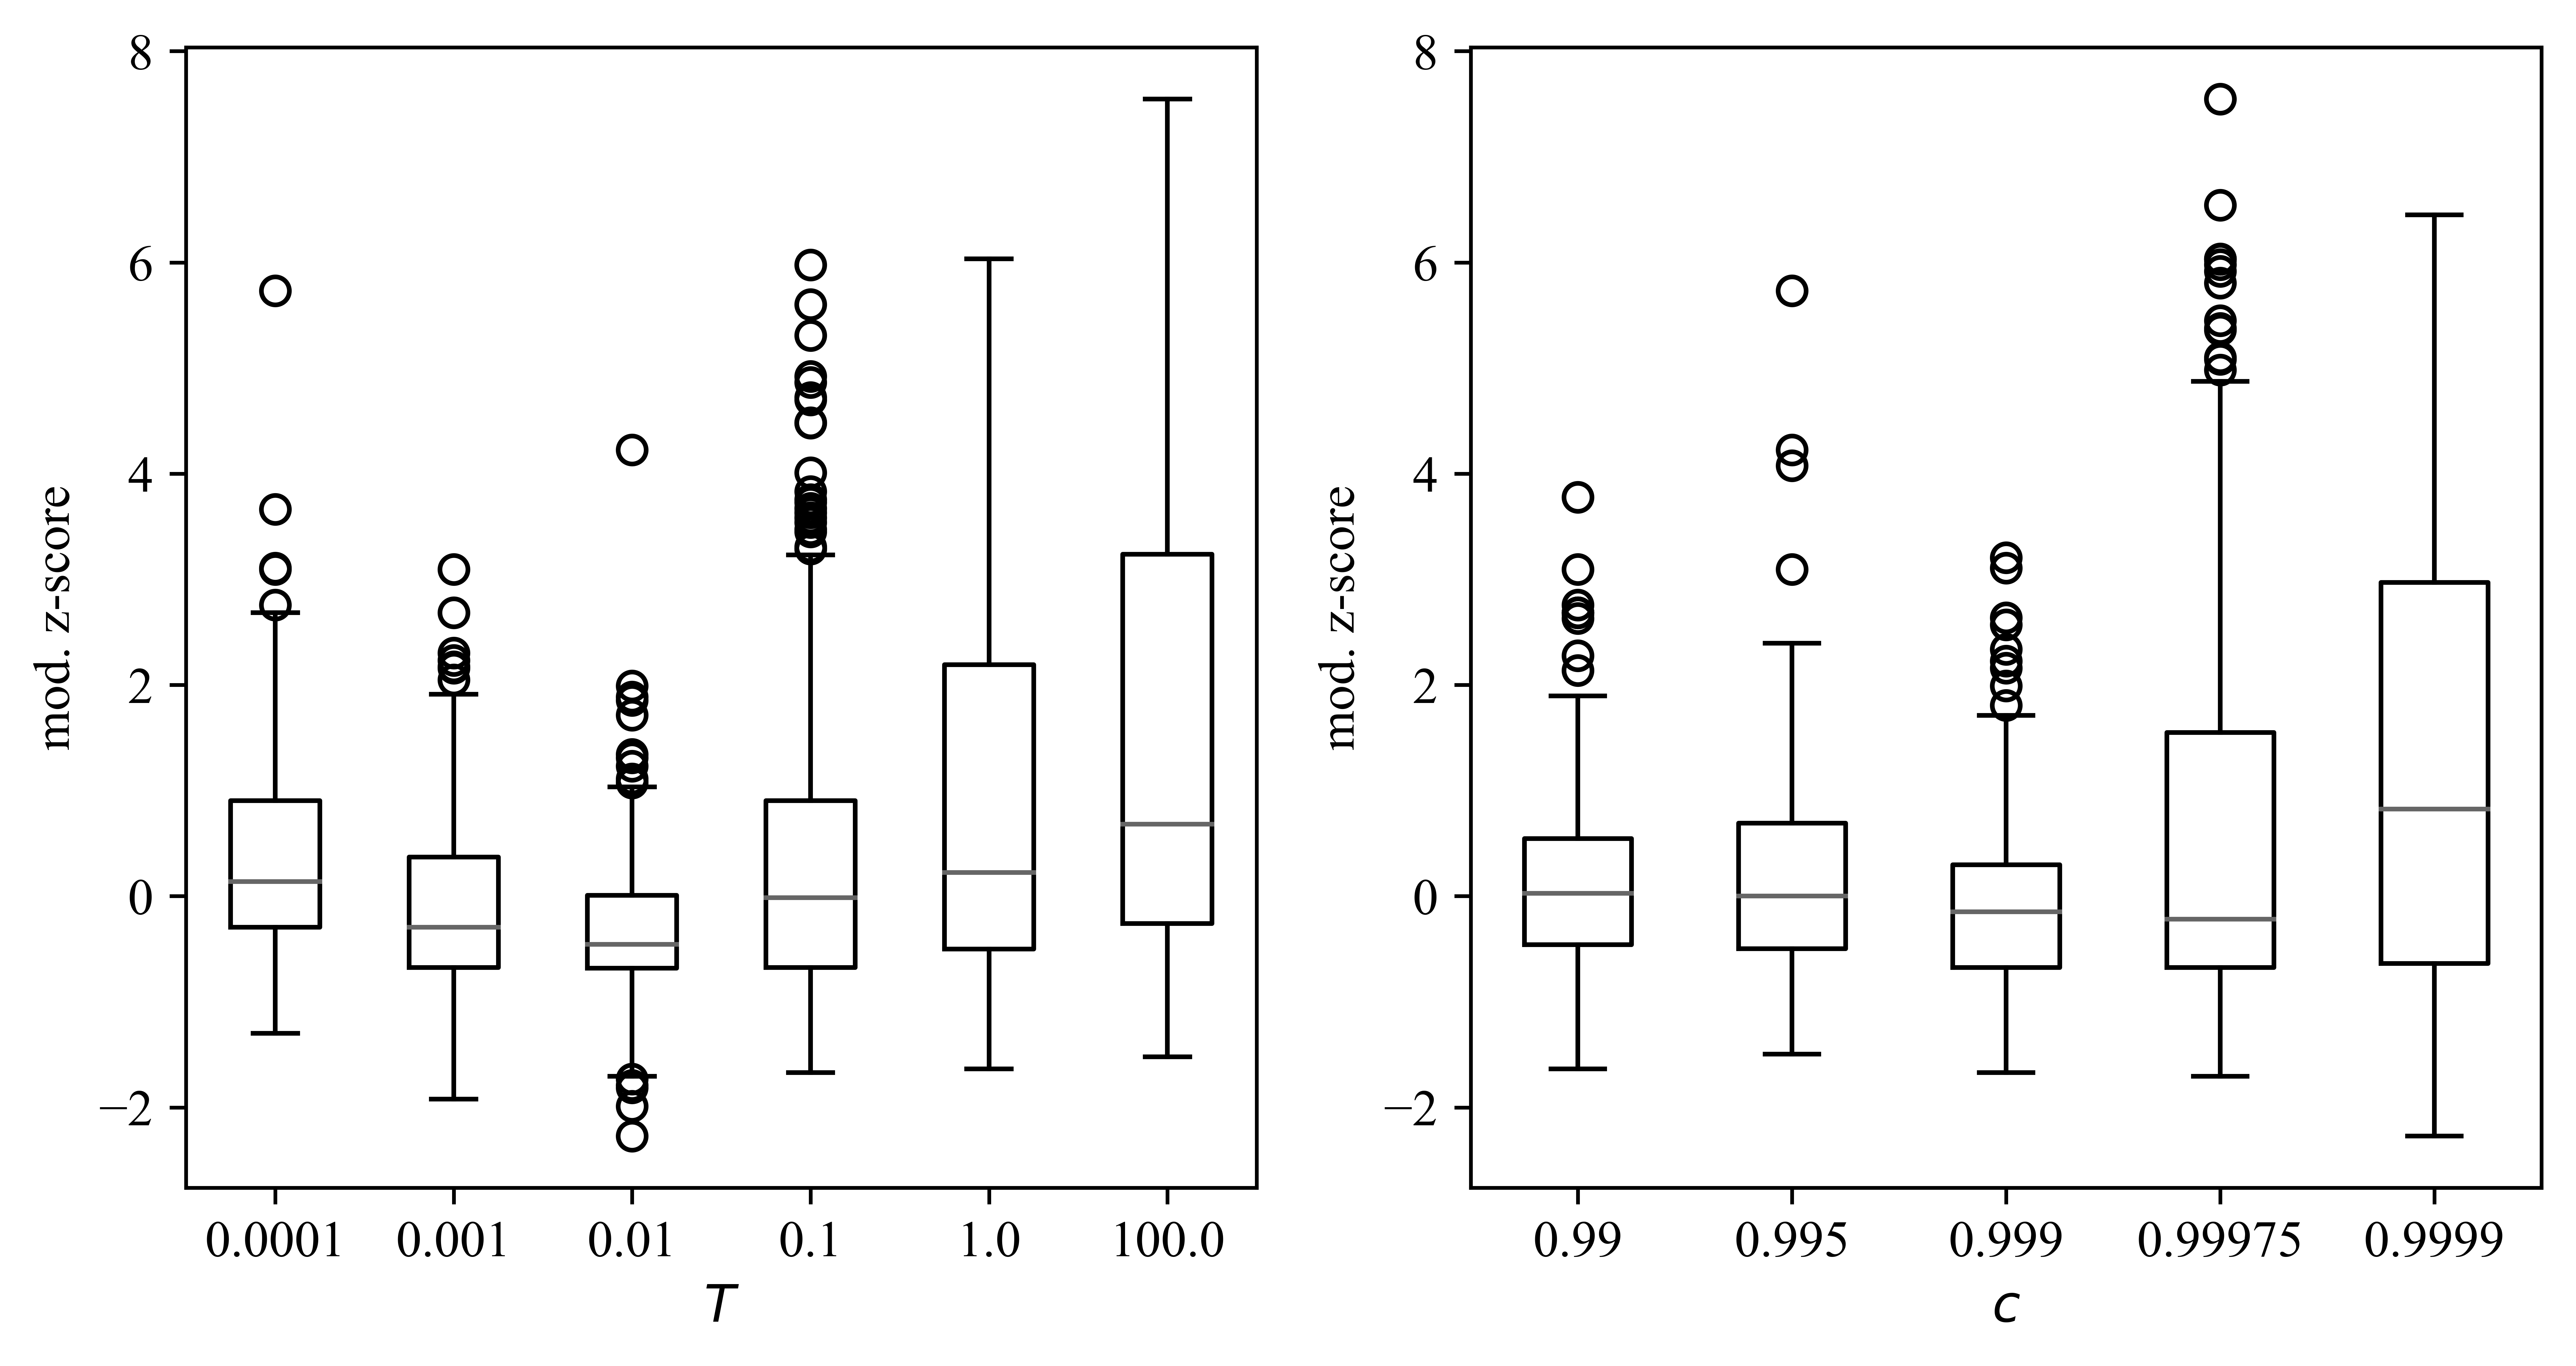

In [13]:
import importlib
importlib.reload(plt)
plt.style.use(['grayscale', 'paper_quer'])

f, (a0, a1) = plt.subplots(1,2, gridspec_kw = {'width_ratios':[1, 1]})
# f.set_size_inches(18.5, 10.5, forward=True)
# f.set_dpi(200)

_ = a0.boxplot(init_data, labels=init_labels)
a0.set_xlabel(f"$ T $")
a0.set_ylabel("mod. z-score")

_ = a1.boxplot(cooling_data, labels=cooling_labels) # assign to mute output print
a1.set_xlabel(f"$ c $")
a1.set_ylabel("mod. z-score")

**Observation 1:** We might assume a combination of 0.01 and 0.999 to work best  
**Observation 2:** 0.1 and 0.995 seems to perform worse individually

### 1.3.2) Plot behaviour of each value combination

Text(0,0.5,'mod. z-scores')

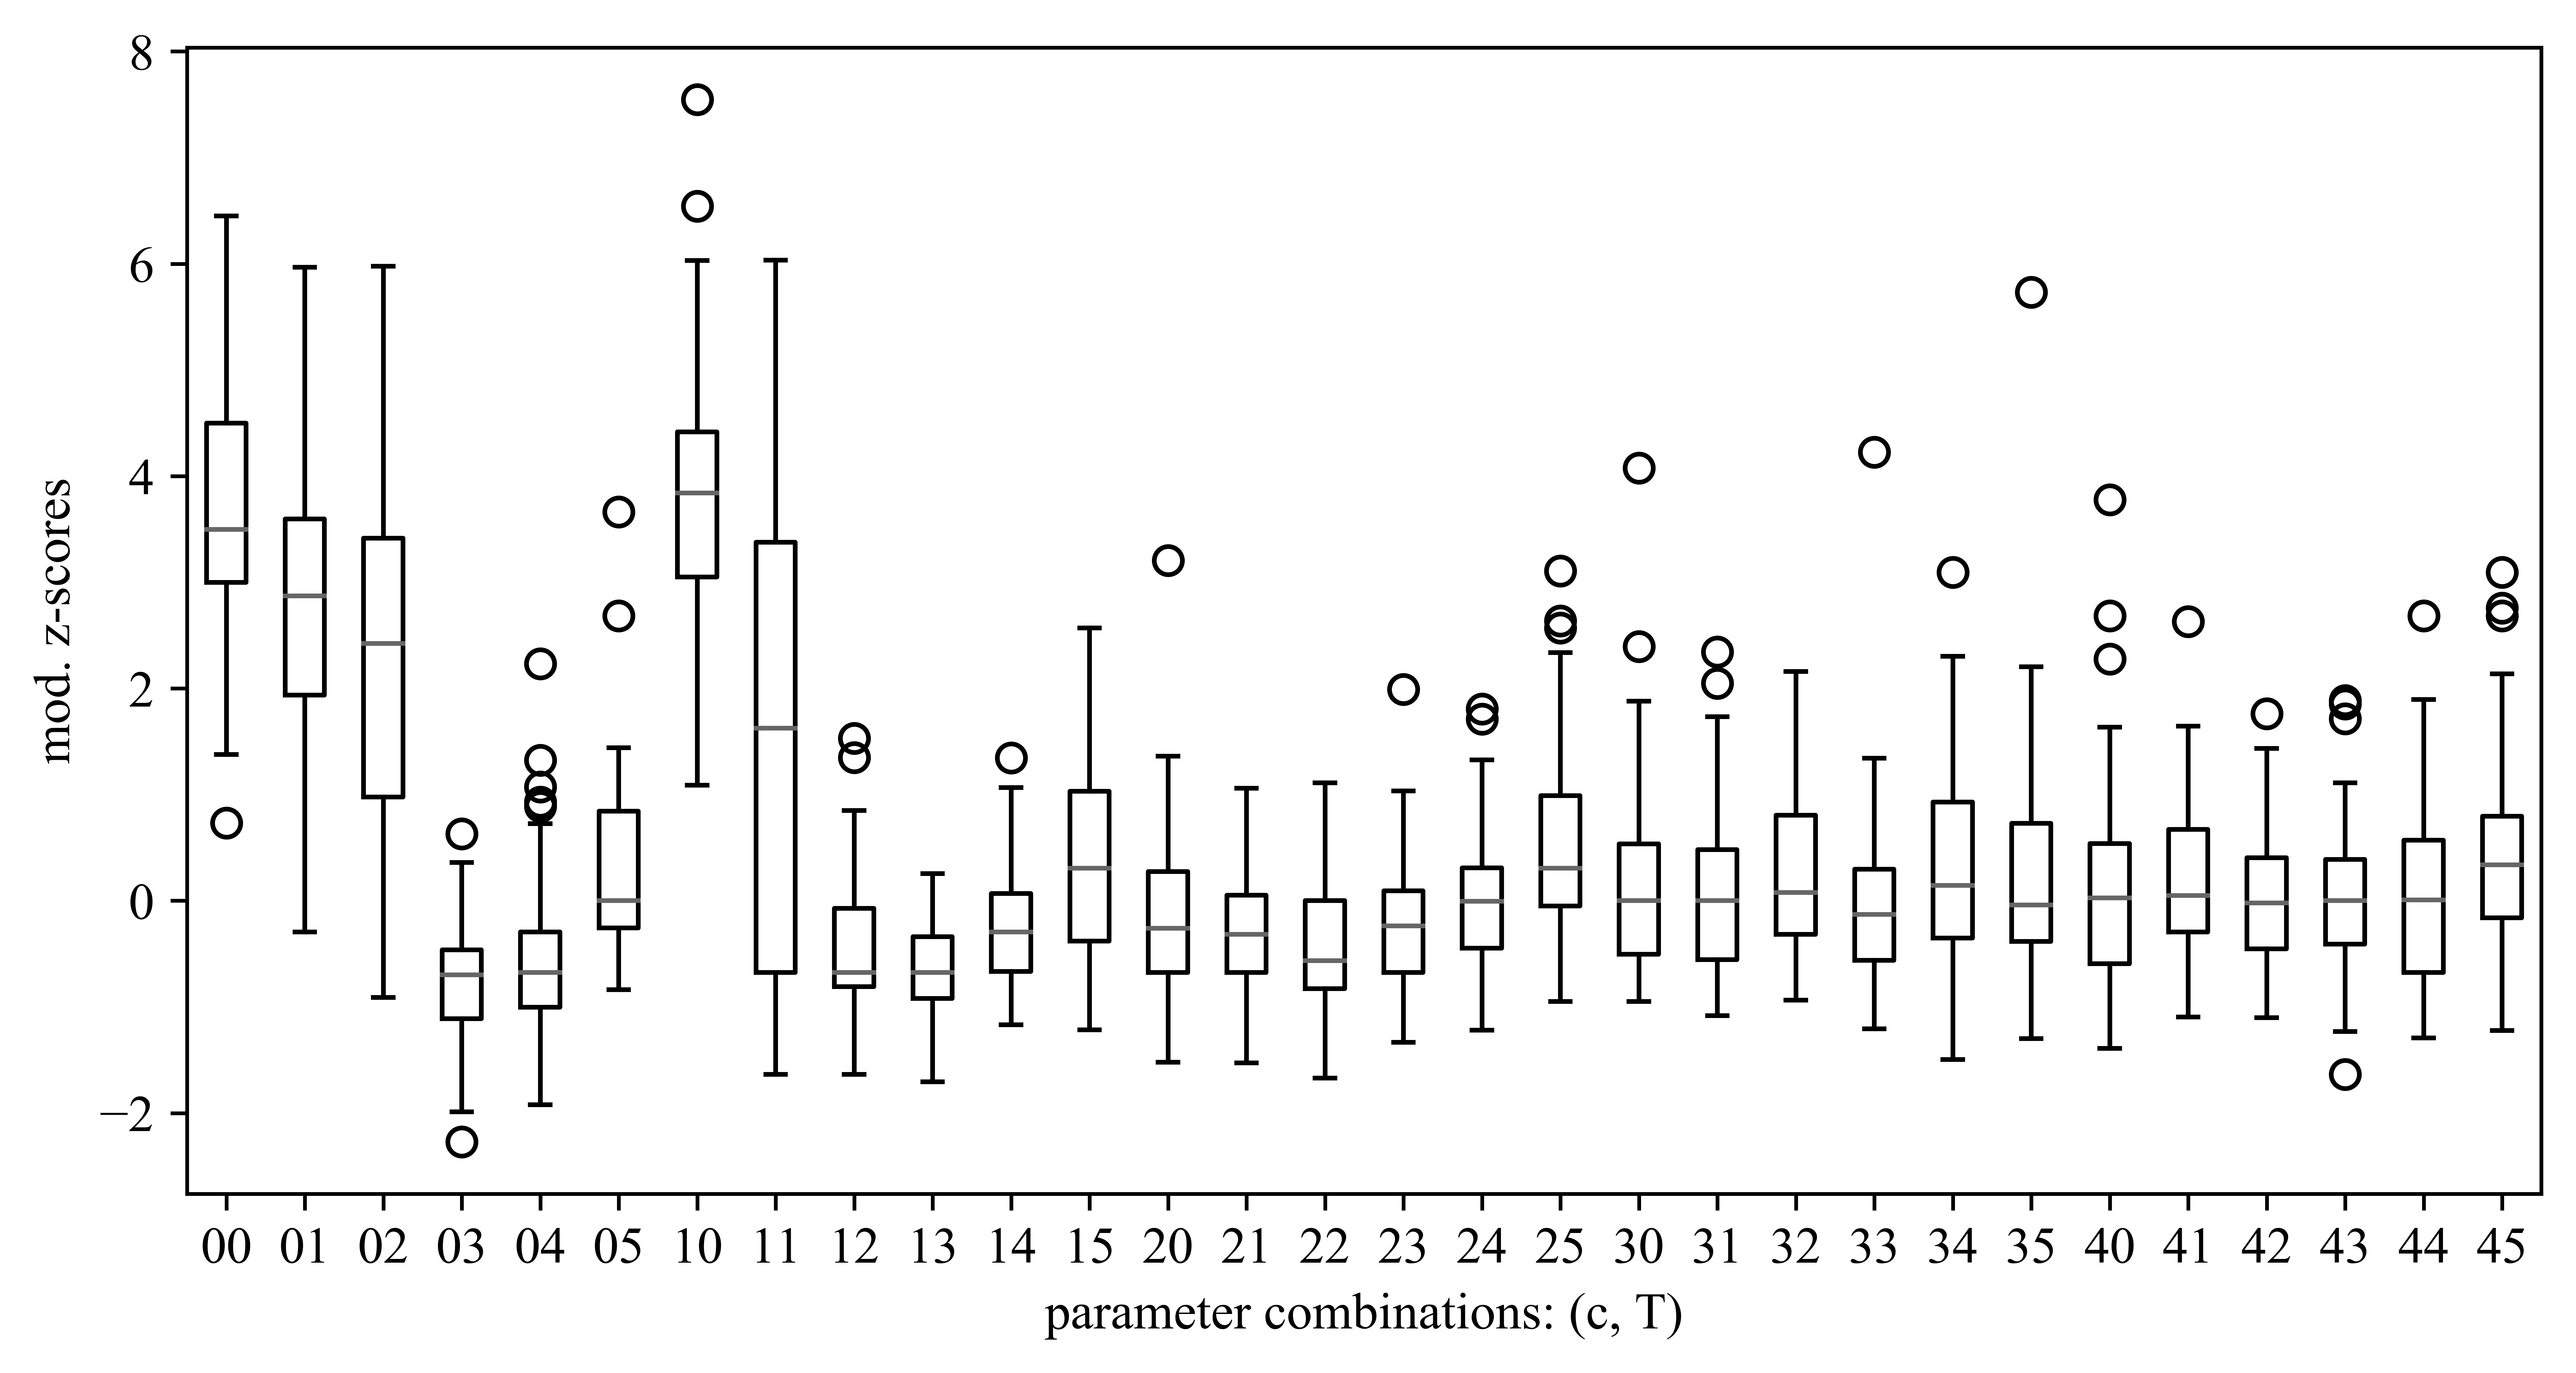

In [14]:
labels = tuple(zip(list(set(df["cooling"])), list(set(df["init_temp"]))))

data = []
labels = []

cooling_labels = list(set(df["cooling"]))
cooling_labels.sort(reverse=True)

init_labels = list(set(df["init_temp"]))
init_labels.sort(reverse=True)

for i, x in enumerate(cooling_labels):
    for j, y in enumerate(init_labels):
        data.append(df[(df["cooling"] == x) & (
            df["init_temp"] == y)]["mod_value"])
        labels.append(f"{i}{j}")
      
import importlib
importlib.reload(plt)
plt.style.use(['grayscale', 'paper_quer'])

# fig, ax = plt.subplots(figsize=(50, 10), dpi=200)
# _ = ax.boxplot(data, labels=labels)

fig, ax = plt.subplots()
fig.set_size_inches(9, 4.5, forward=True) #adjust size to fit double lined caption
_ = ax.boxplot(data, labels=labels)
ax.set_xlabel("parameter combinations: (c, T)")
ax.set_ylabel("mod. z-scores")

**Observation 3**: The most robust and promising combination seems to be 0.99975 and 0.01

### 1.3.3) Plot all alternatives next to each other

Text(0,0.5,'mod. z-scores')

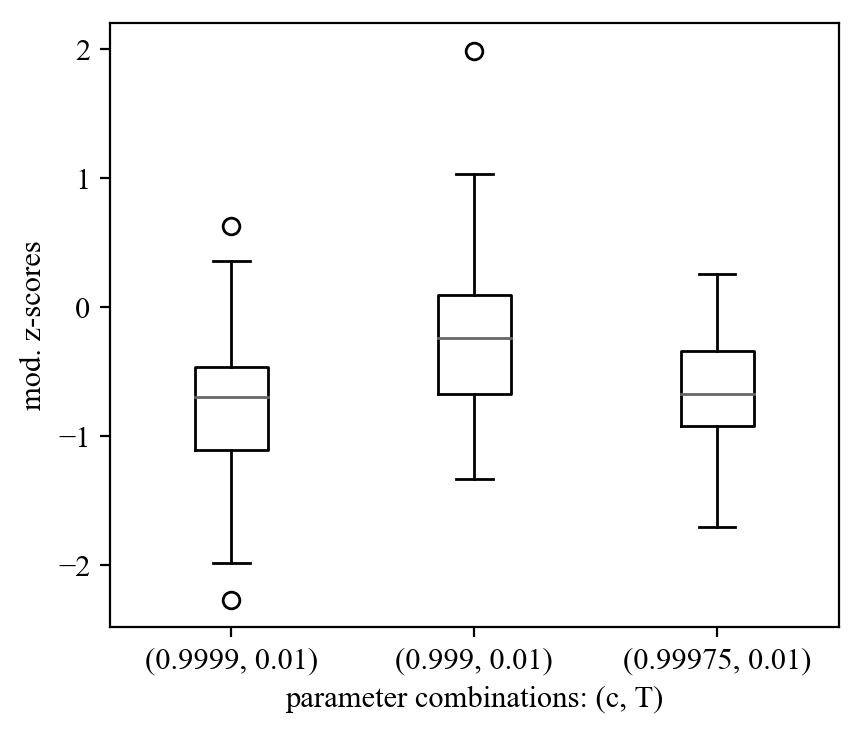

In [21]:
import importlib
importlib.reload(plt)
plt.style.use(['grayscale', 'paper_hoch'])

data2 = []
data2.append(df[(df["init_temp"] == 0.01) & (
    df["cooling"] == 0.9999)]["mod_value"])
data2.append(df[(df["init_temp"] == 0.01) & (
    df["cooling"] == 0.999)]["mod_value"])
data2.append(df[(df["init_temp"] == 0.01) & (
    df["cooling"] == 0.99975)]["mod_value"])

fig, ax = plt.subplots()
_ = ax.boxplot(data2, labels=["(0.9999, 0.01)", "(0.999, 0.01)", "(0.99975, 0.01)"])
ax.set_xlabel("parameter combinations: (c, T)")
ax.set_ylabel("mod. z-scores")

**Final observation**

1) The greedy approach of the tree learner failed
2) Selecting the best single values gets stuck in a local minimum

**Both approaches are flawed!**  
**However:** Not possible to bruteforce all combinations in the following iterations!

# 2) Analyse best search radius

In [84]:
path = "C:\\Users\\manuf\\OneDrive\\Dokumente\\Universitaet\\Masterthesis\\data\\1_tuning_results\\vrpldtt"
solutions = get_solutions(join(path, "2_search_space"))

raw_data = [[row["data_id"],
             row["parameter"]["shakeup_log"],
             row["parameter"]["mean_removal_log"],
             row["metrics"]["value"],
             row["metrics"]["iterations"],
             row["metrics"]["solution_time_ms"]]
            for row in solutions]

df = pd.DataFrame(raw_data, columns=[
                  "id", "shakeup", "mean_removal", "value", "iterations", "solution_time_ms"])

df["mod_value"] = get_modified_z_scores_ids(df["value"], df["id"])
df["mod_iterations"] = get_modified_z_scores_ids(df["iterations"], df["id"])
df["mod_time"] = get_modified_z_scores_ids(df["solution_time_ms"], df["id"])

# remove outlier detection
df = df[df["mod_value"] < 3]

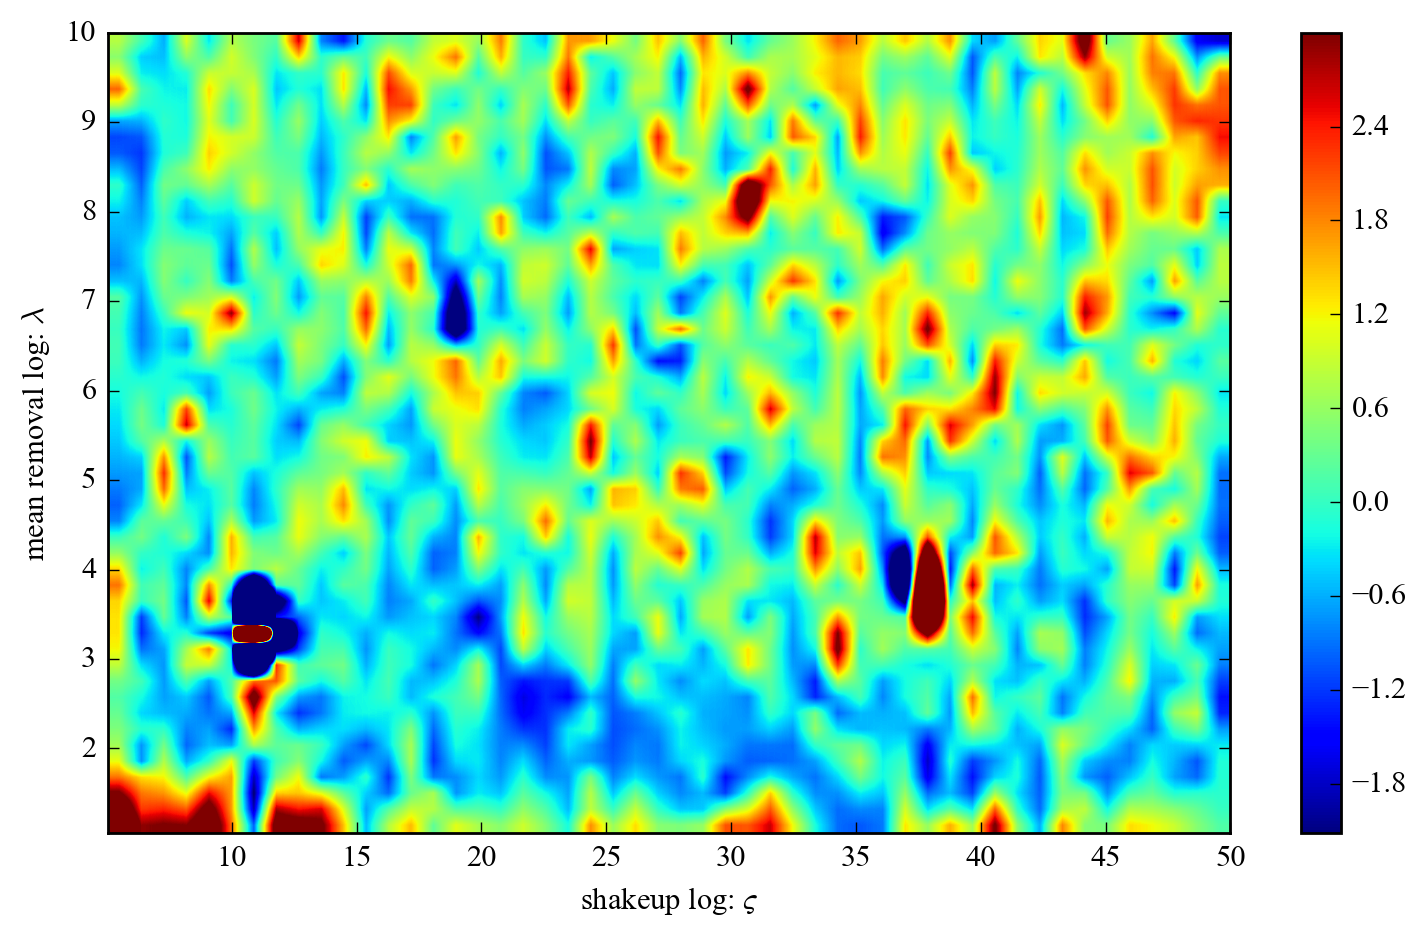

In [85]:
# Set up a regular grid of interpolation points
x = df["shakeup"].values #[:100]
y = df["mean_removal"].values #[:100]
z = df["mod_value"].values #[:100]

# Get value ranges and build meshgrid as foundation
xi, yi = np.linspace(x.min(), x.max(), 50), np.linspace(y.min(), y.max(), 50)
xi, yi = np.meshgrid(xi, yi)

# Interpolate values
rbf = scipy.interpolate.Rbf(x, y, z, function='thin_plate', smooth=0.00001)
zi = rbf(xi, yi)
plt.style.use(['classic', 'paper_quer_broad'])
plt.imshow(zi, vmin=z.min(), vmax=z.max(), origin='lower',
           extent=[x.min(), x.max(), y.min(), y.max()], aspect="auto")
plt.xlabel(f"shakeup log: $ ς $")
plt.ylabel(f"mean removal log: $ \lambda $")
#plt.scatter(x, y, c=z)
plt.colorbar()
plt.show()

**Observation 1**: Low mean removal and low mean shakeup -> bad performance (lower corner)  
**Observation 2**: Big deep region in shakeup log [10-13] and [3-4] BUT: there is a red region aswell. High chance to polarize!  
**Observation 3**: Region between shakeup log [20-25] and mean removal log [2-3]. Seems robust and not as polarizing  

Tendency in regards to number of customers?

# 3) Diversity analysis

In [18]:
path = "C:\\Users\\manuf\\OneDrive\\Dokumente\\Universitaet\\Masterthesis\\data\\1_tuning_results\\vrpldtt"
solutions = get_solutions(join(path, "4_operator_weights"))
values = np.array([sol["metrics"]["value"]for sol in solutions])
ids = np.array([sol["data_id"] for sol in solutions])

all_x = np.array([[sol["parameter"]["functor_reward_best"],
                   sol["parameter"]["functor_reward_accept_better"],
                   sol["parameter"]["functor_reward_divers"],
                   sol["parameter"]["functor_reward_unique"],
                   sol["parameter"]["functor_penalty"],
                   sol["parameter"]["random_noise"]] for sol in solutions])
all_y = get_modified_z_scores_ids(values, ids)

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [ ]:
import importlib
importlib.reload(plt)
plt.style.use(['grayscale', 'paper_quer'])

size_info = {50: [0, 3],
             100: [1, 5],
             200: [2, 4]}

for i, size in enumerate(size_info):
    fig, axs = plt.subplots(1, 1)
    fig.set_size_inches(3, 4.5, forward=True)
    
    y = []
    for id in size_info[size]:
        l_case = [id_val == id for id_val in ids]
        y.extend(all_y[l_case])

    axs.hist(y, edgecolor="royalblue", linewidth=0.5, bins=100, density=True)
    axs.set_xlim(-4, 15)
    axs.set_ylim(0, 1)
    axs.set_xlabel("mod. z-scores")
    axs.set_ylabel("probability density")

# Weight tuning

## Data import

In [ ]:
path = "C:\\Users\\manuf\\OneDrive\\Dokumente\\Universitaet\\Masterthesis\\data\\1_tuning_results\\vrpldtt"
solutions = get_solutions(join(path, "4_operator_weights"))
values = np.array([sol["metrics"]["value"]for sol in solutions])
ids = np.array([sol["data_id"] for sol in solutions])

all_x = np.array([[sol["parameter"]["functor_reward_best"],
               sol["parameter"]["functor_reward_accept_better"],
              sol["parameter"]["functor_reward_divers"],
              sol["parameter"]["functor_reward_unique"],
              sol["parameter"]["functor_penalty"]] for sol in solutions])
all_y = get_modified_z_scores_ids(values, ids)

In [ ]:
len(ids)

## Plot single parameters

In [ ]:
import math
import matplotlib.pyplot as plt 
import importlib
import numpy as np
importlib.reload(plt)
plt.style.use(['grayscale', 'paper_hoch2'])

col_names = ["reward best", "reward imp.", "reward divers", "reward unique", "penalty"]

max_nr = 6000
# perform log transformation
for col in range(len(all_x[0])):
    plt_x = [row[col] for row in all_x[:max_nr]]
    
    # train regression line on it!
    m,b = np.polyfit(plt_x, all_y[:max_nr], 1)
    
    reg_x = list(np.arange(min(plt_x), max(plt_x), 0.01))
    reg_y = [m*x + b for x in reg_x]
    
    plt.scatter(plt_x, all_y[:max_nr], s=0.03)
    plt.plot(reg_x, reg_y, color="royalblue")
    plt.xlabel(f"{col_names[col]}: $\sigma_{col+1}$")
    plt.ylabel("mod. z-score")
    plt.show()

## Plot draw frequency

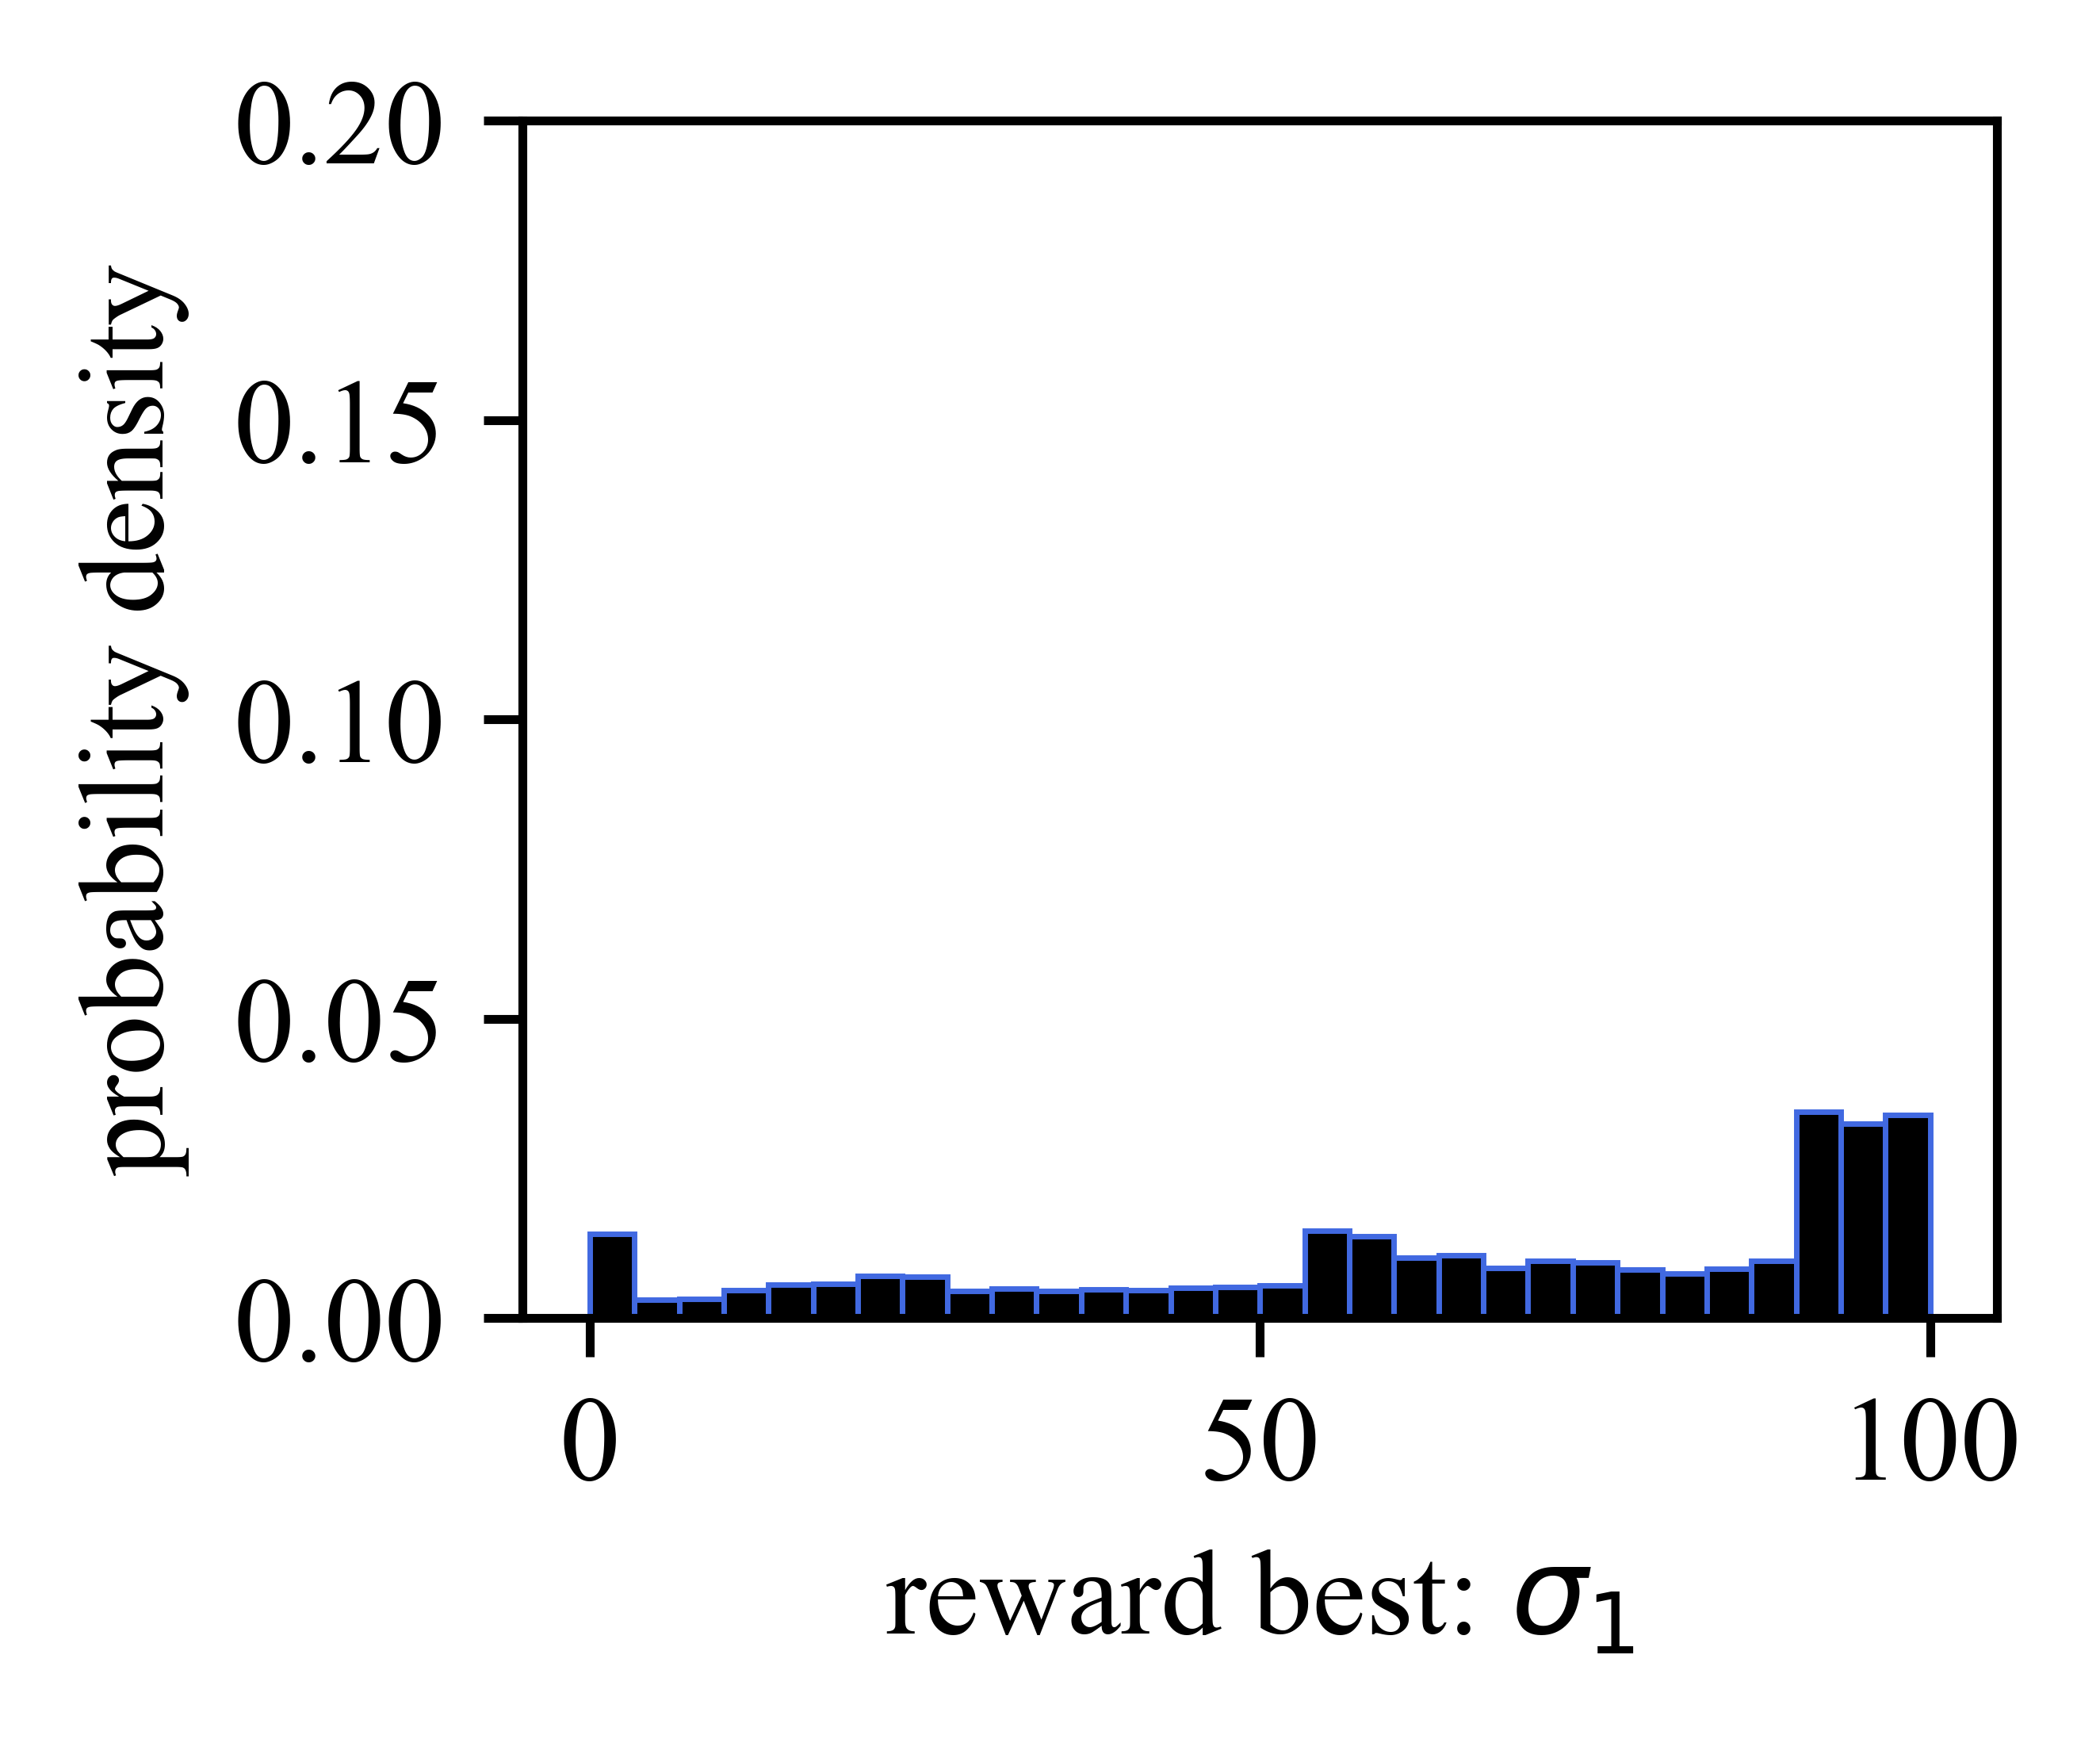

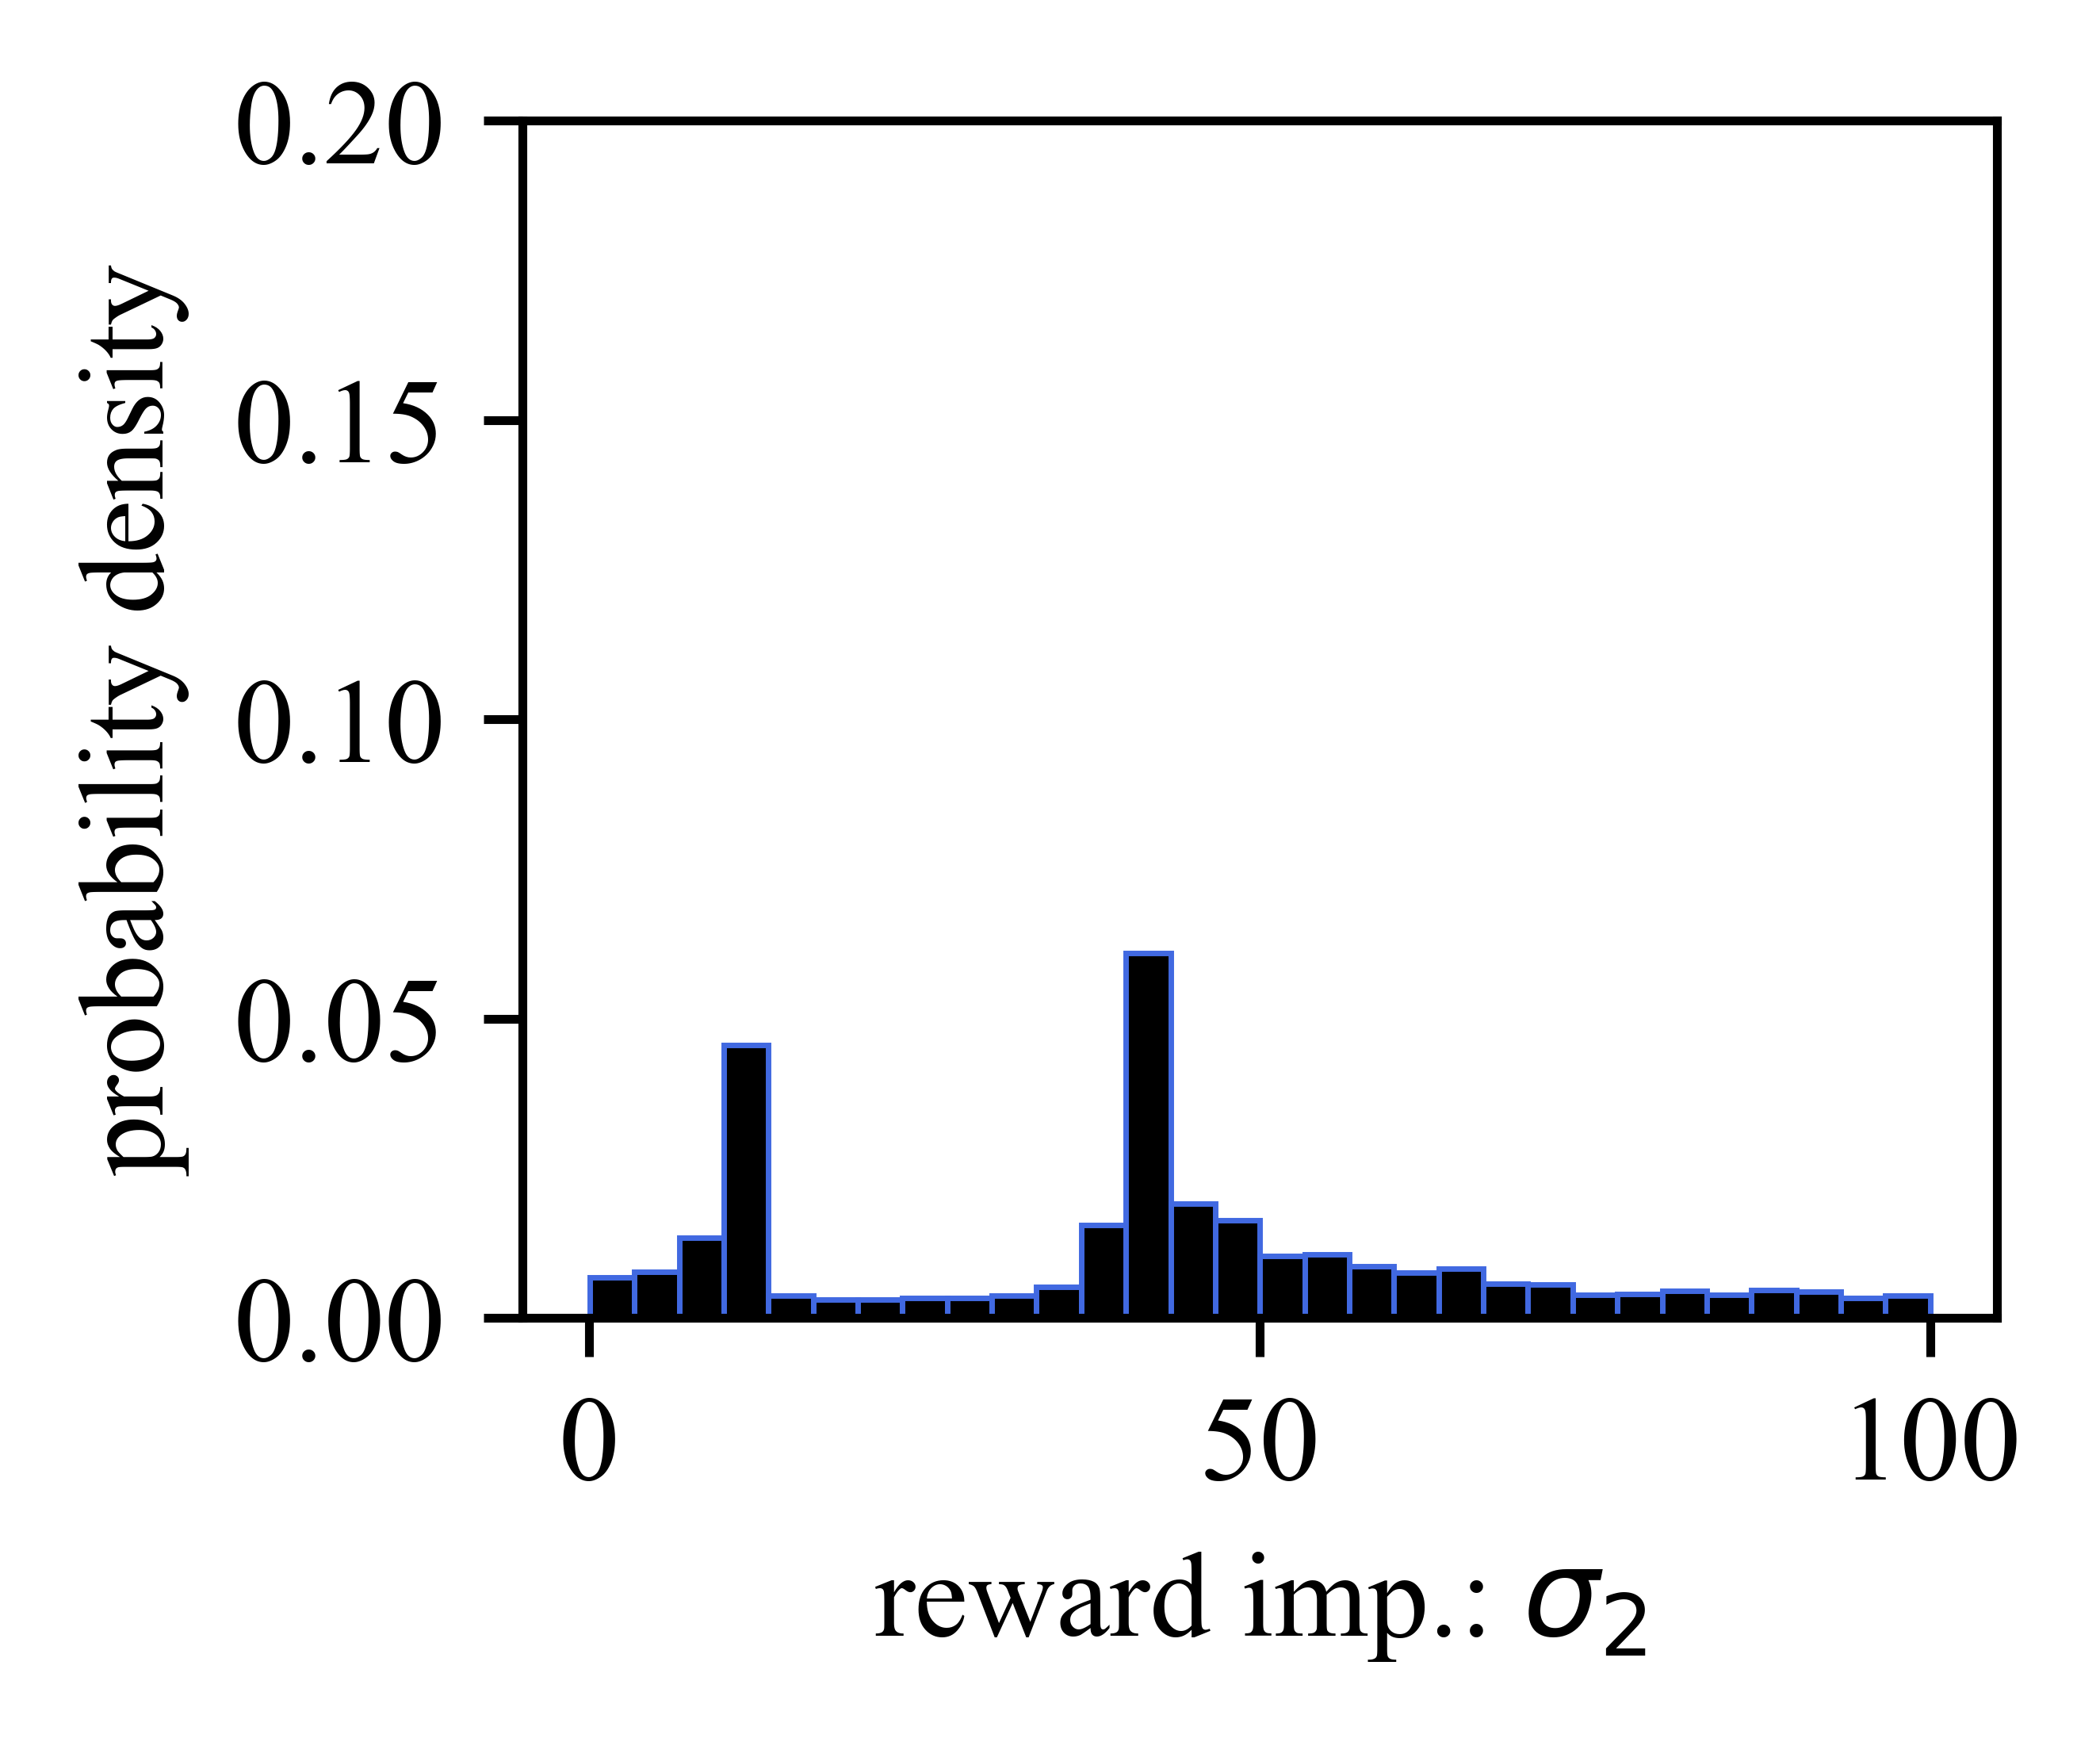

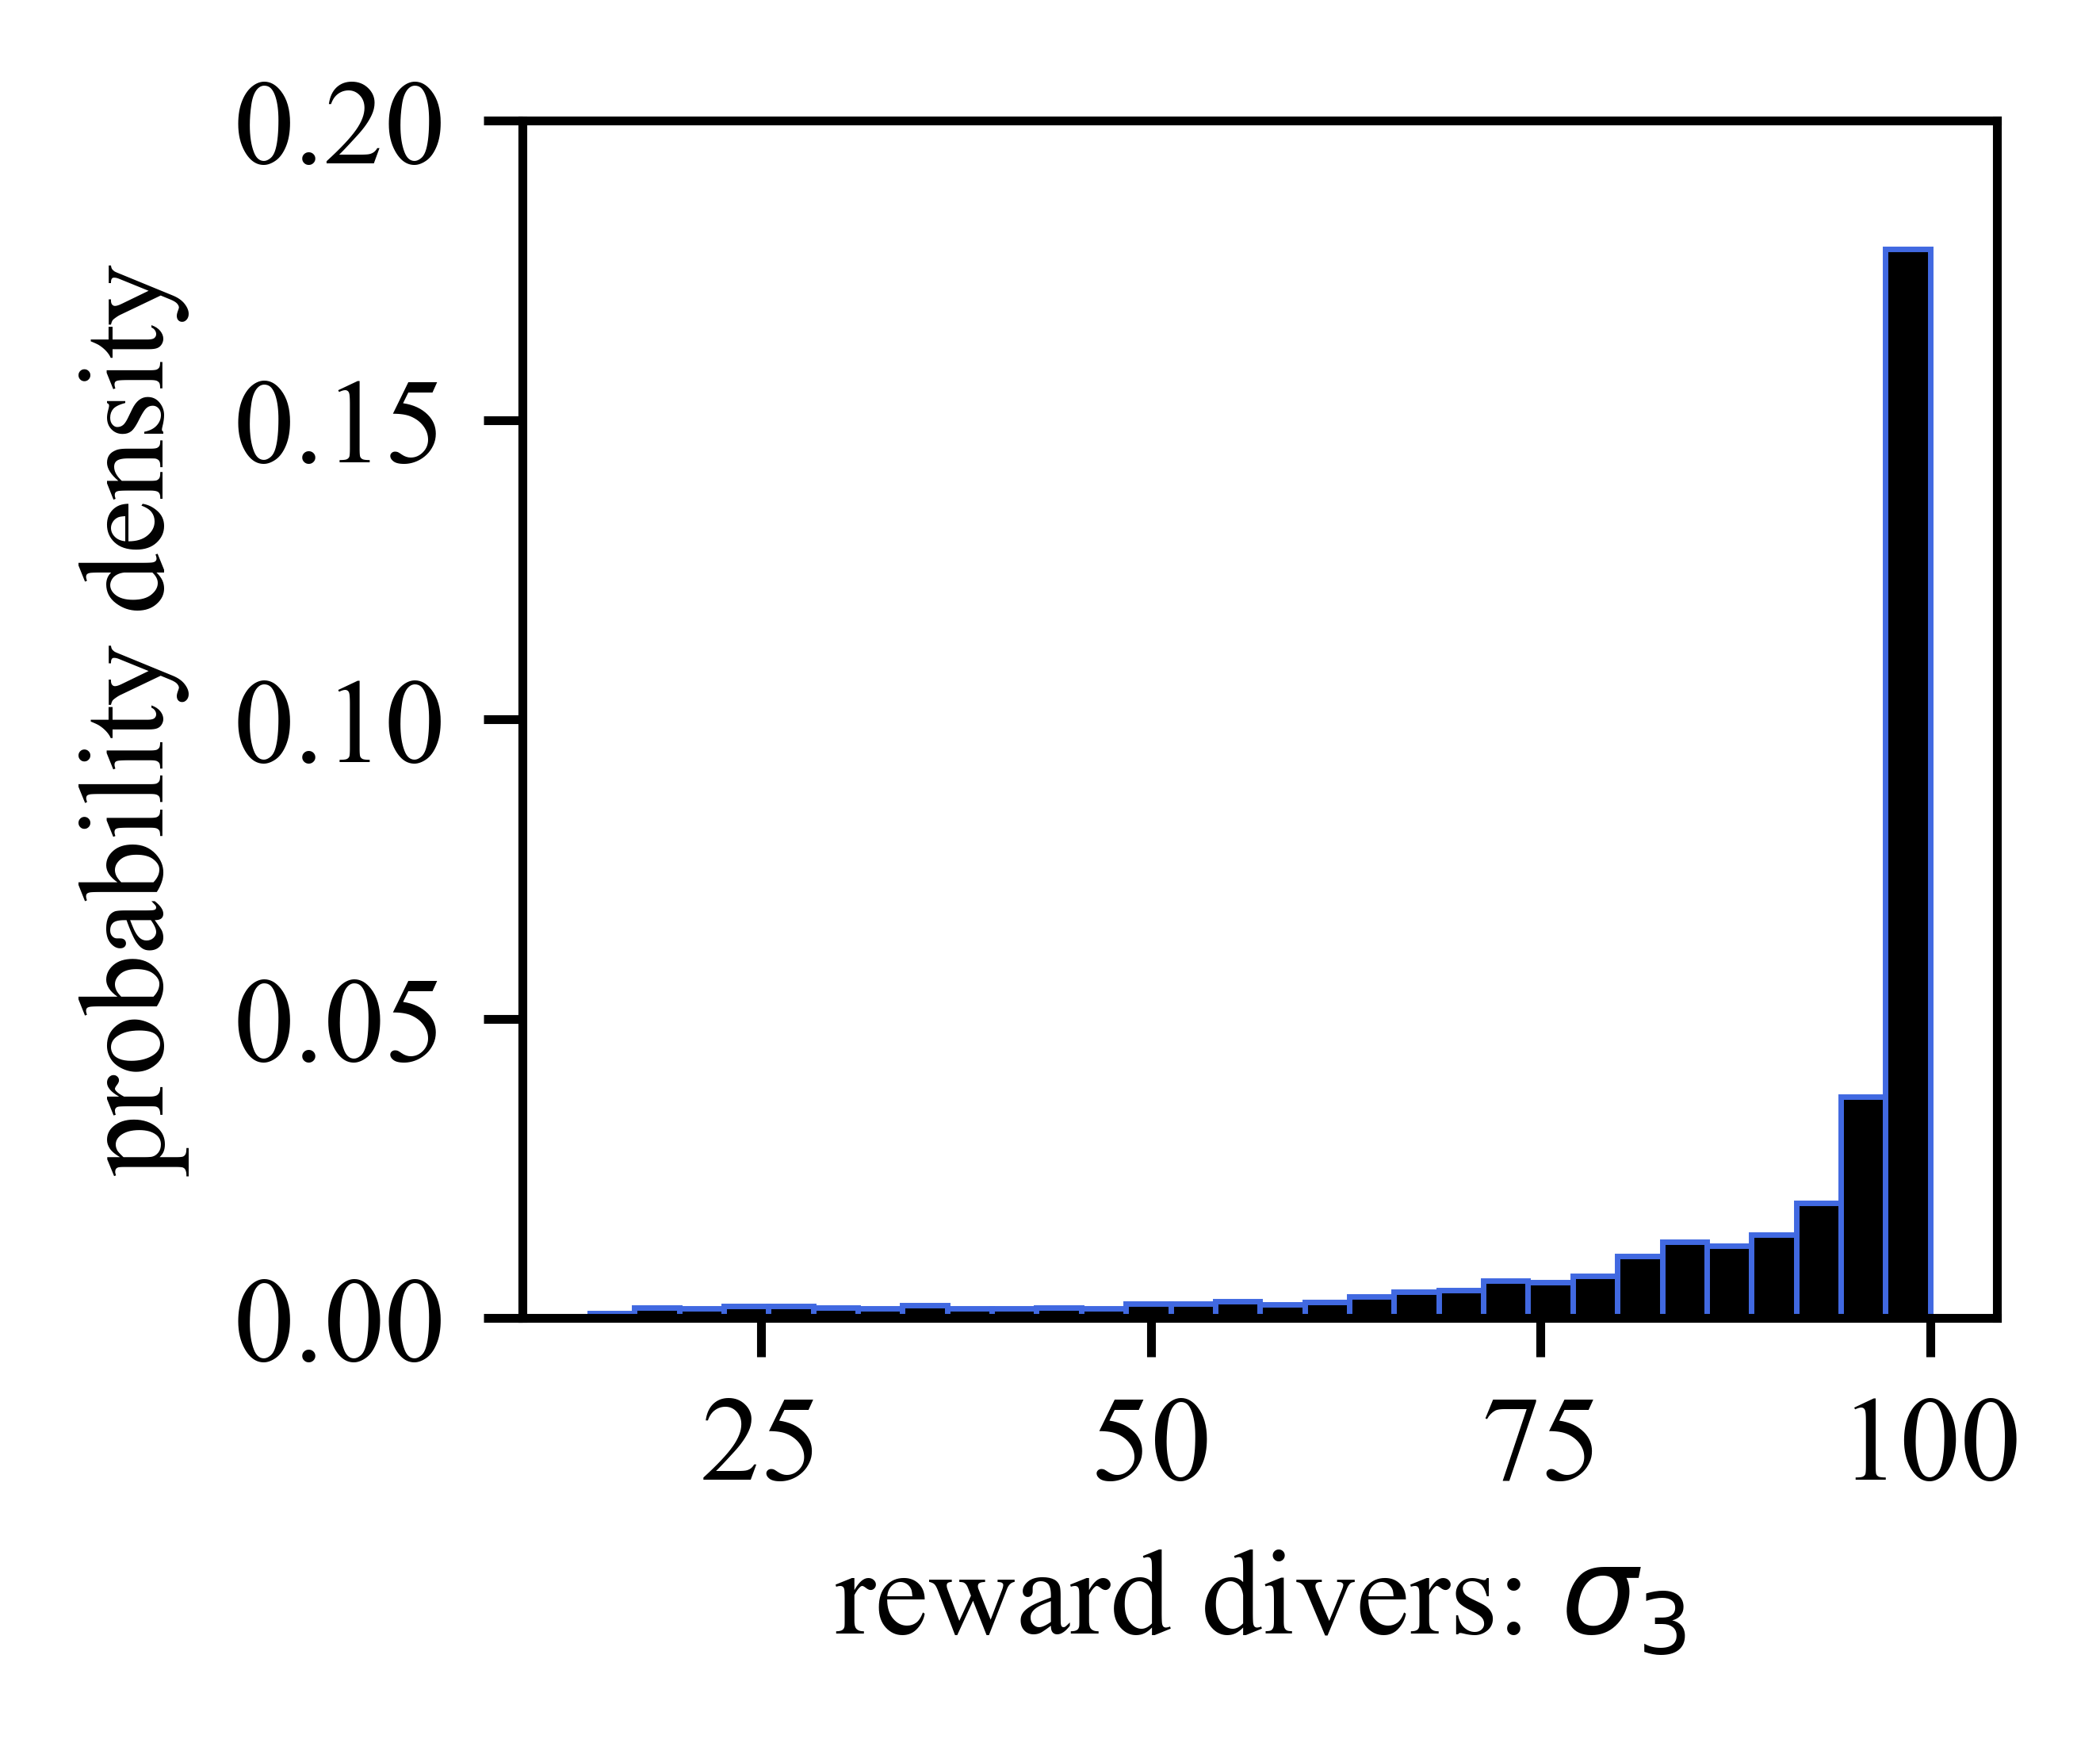

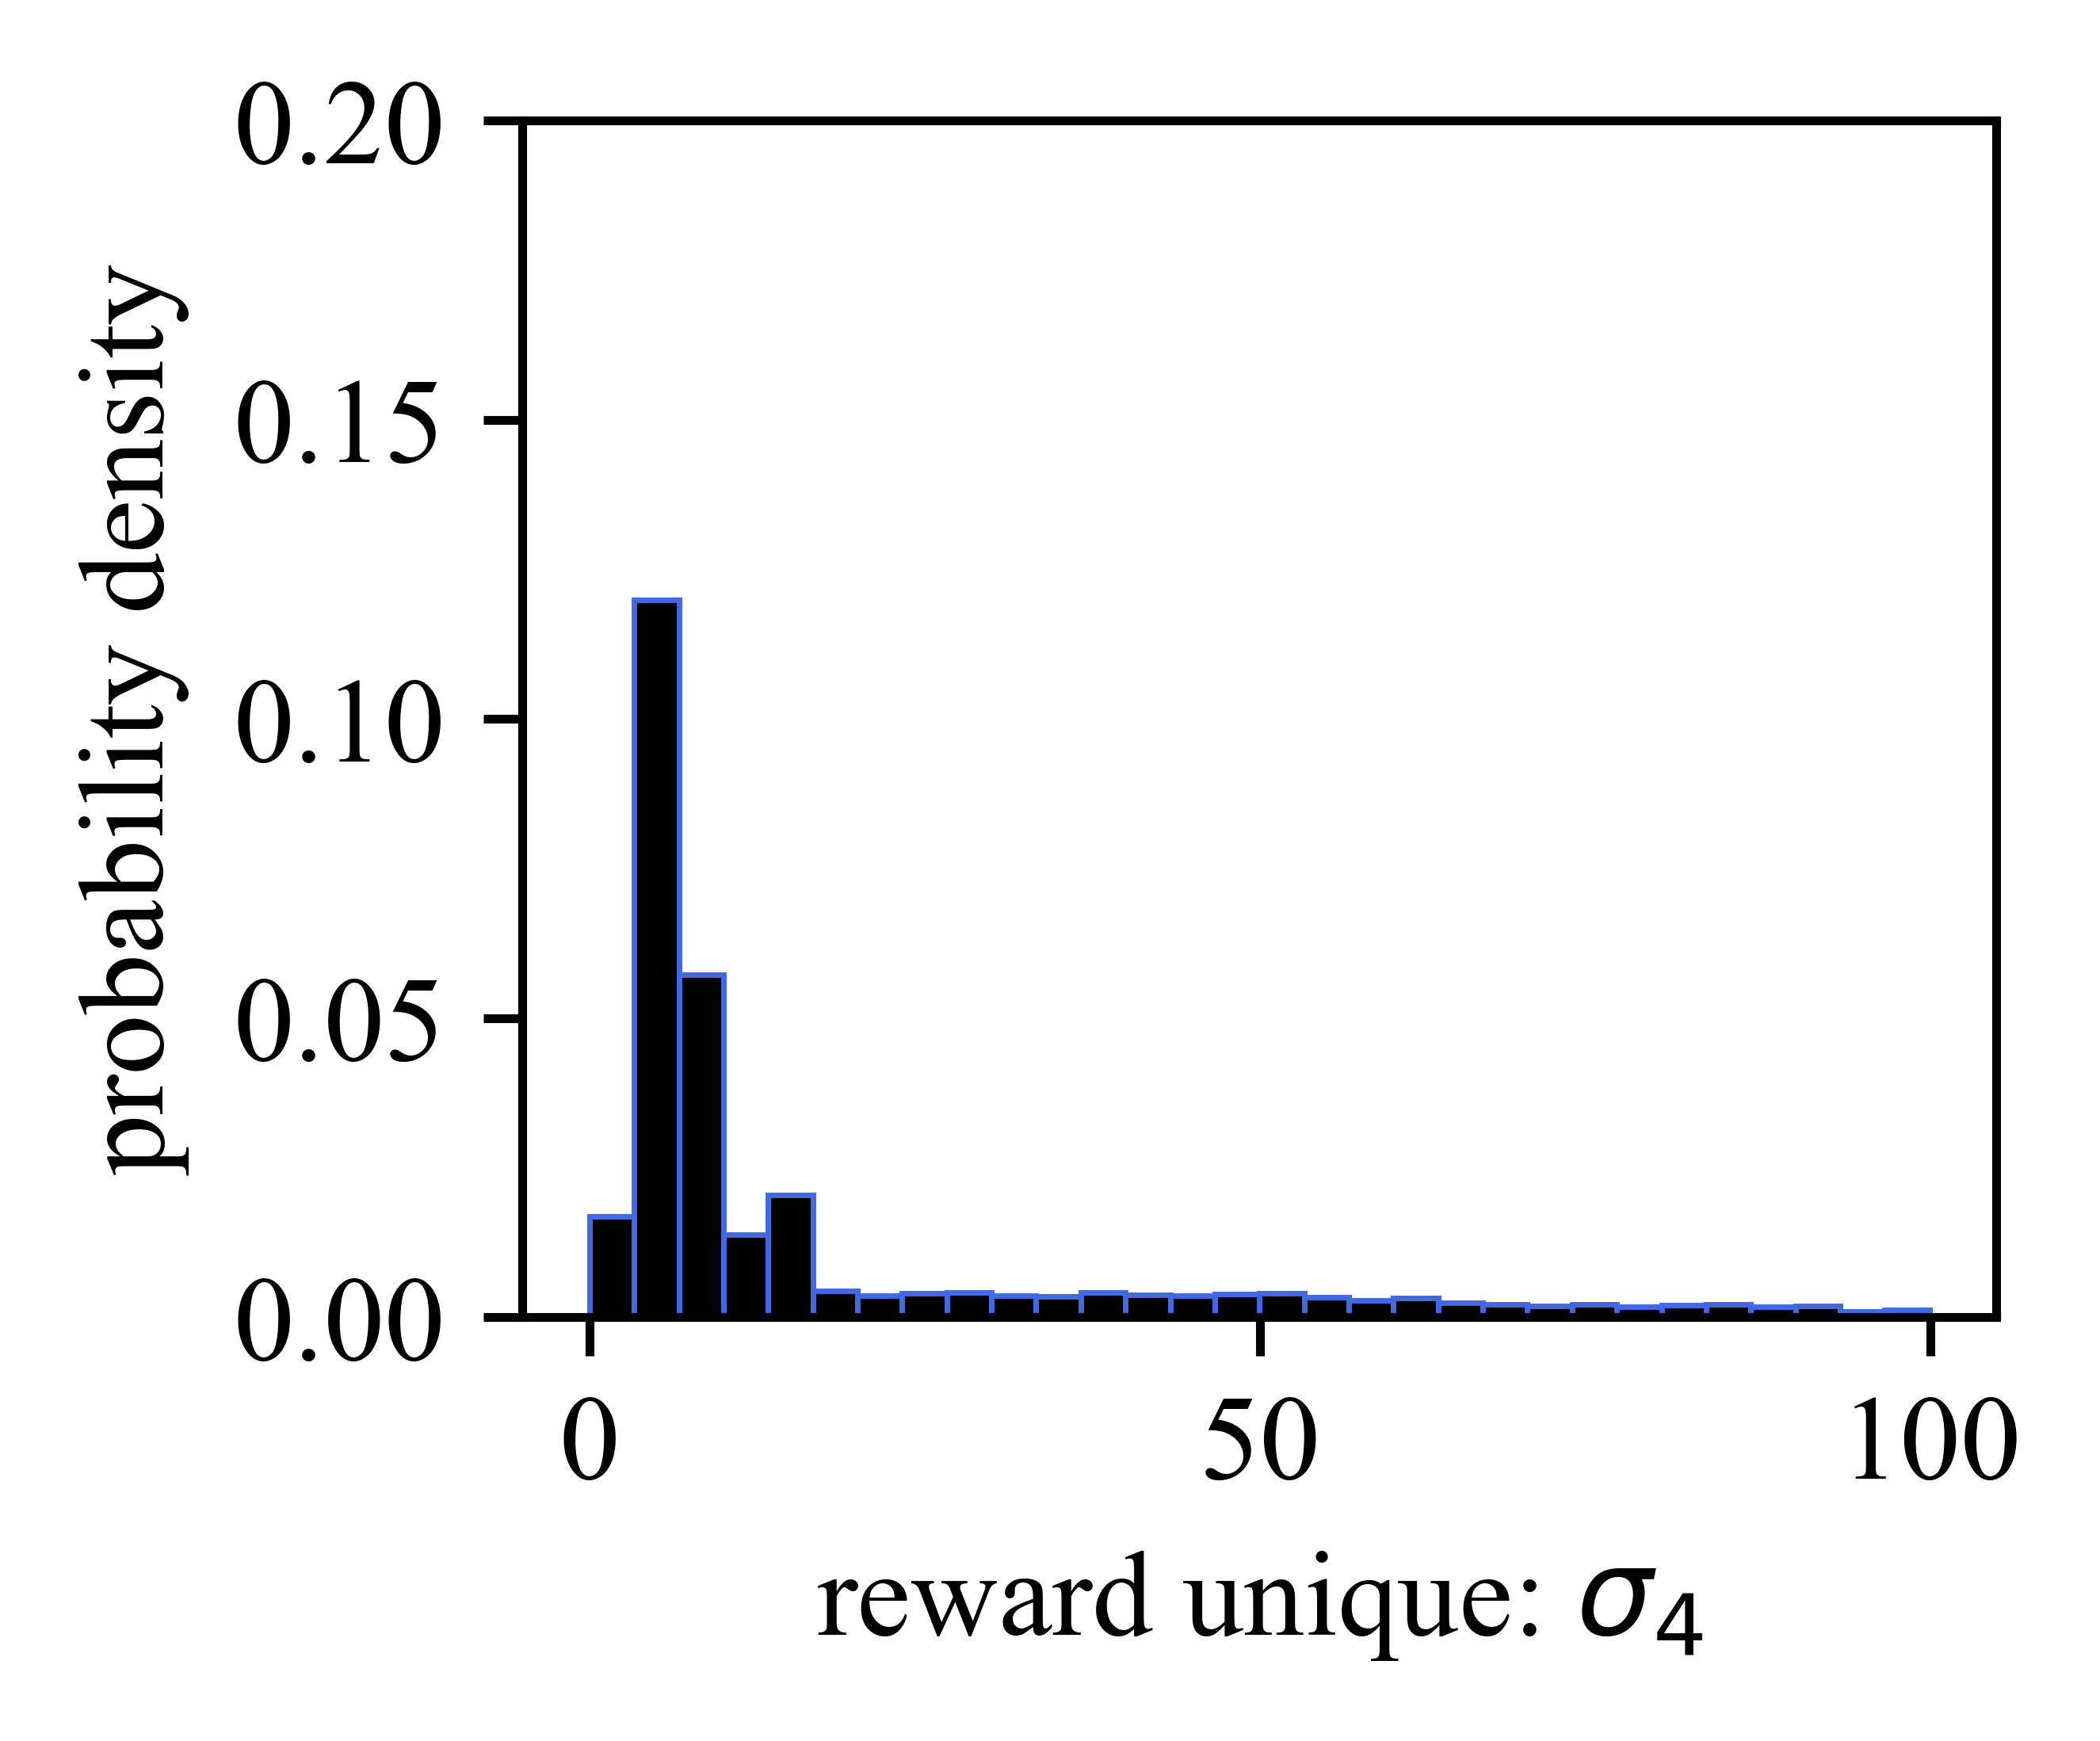

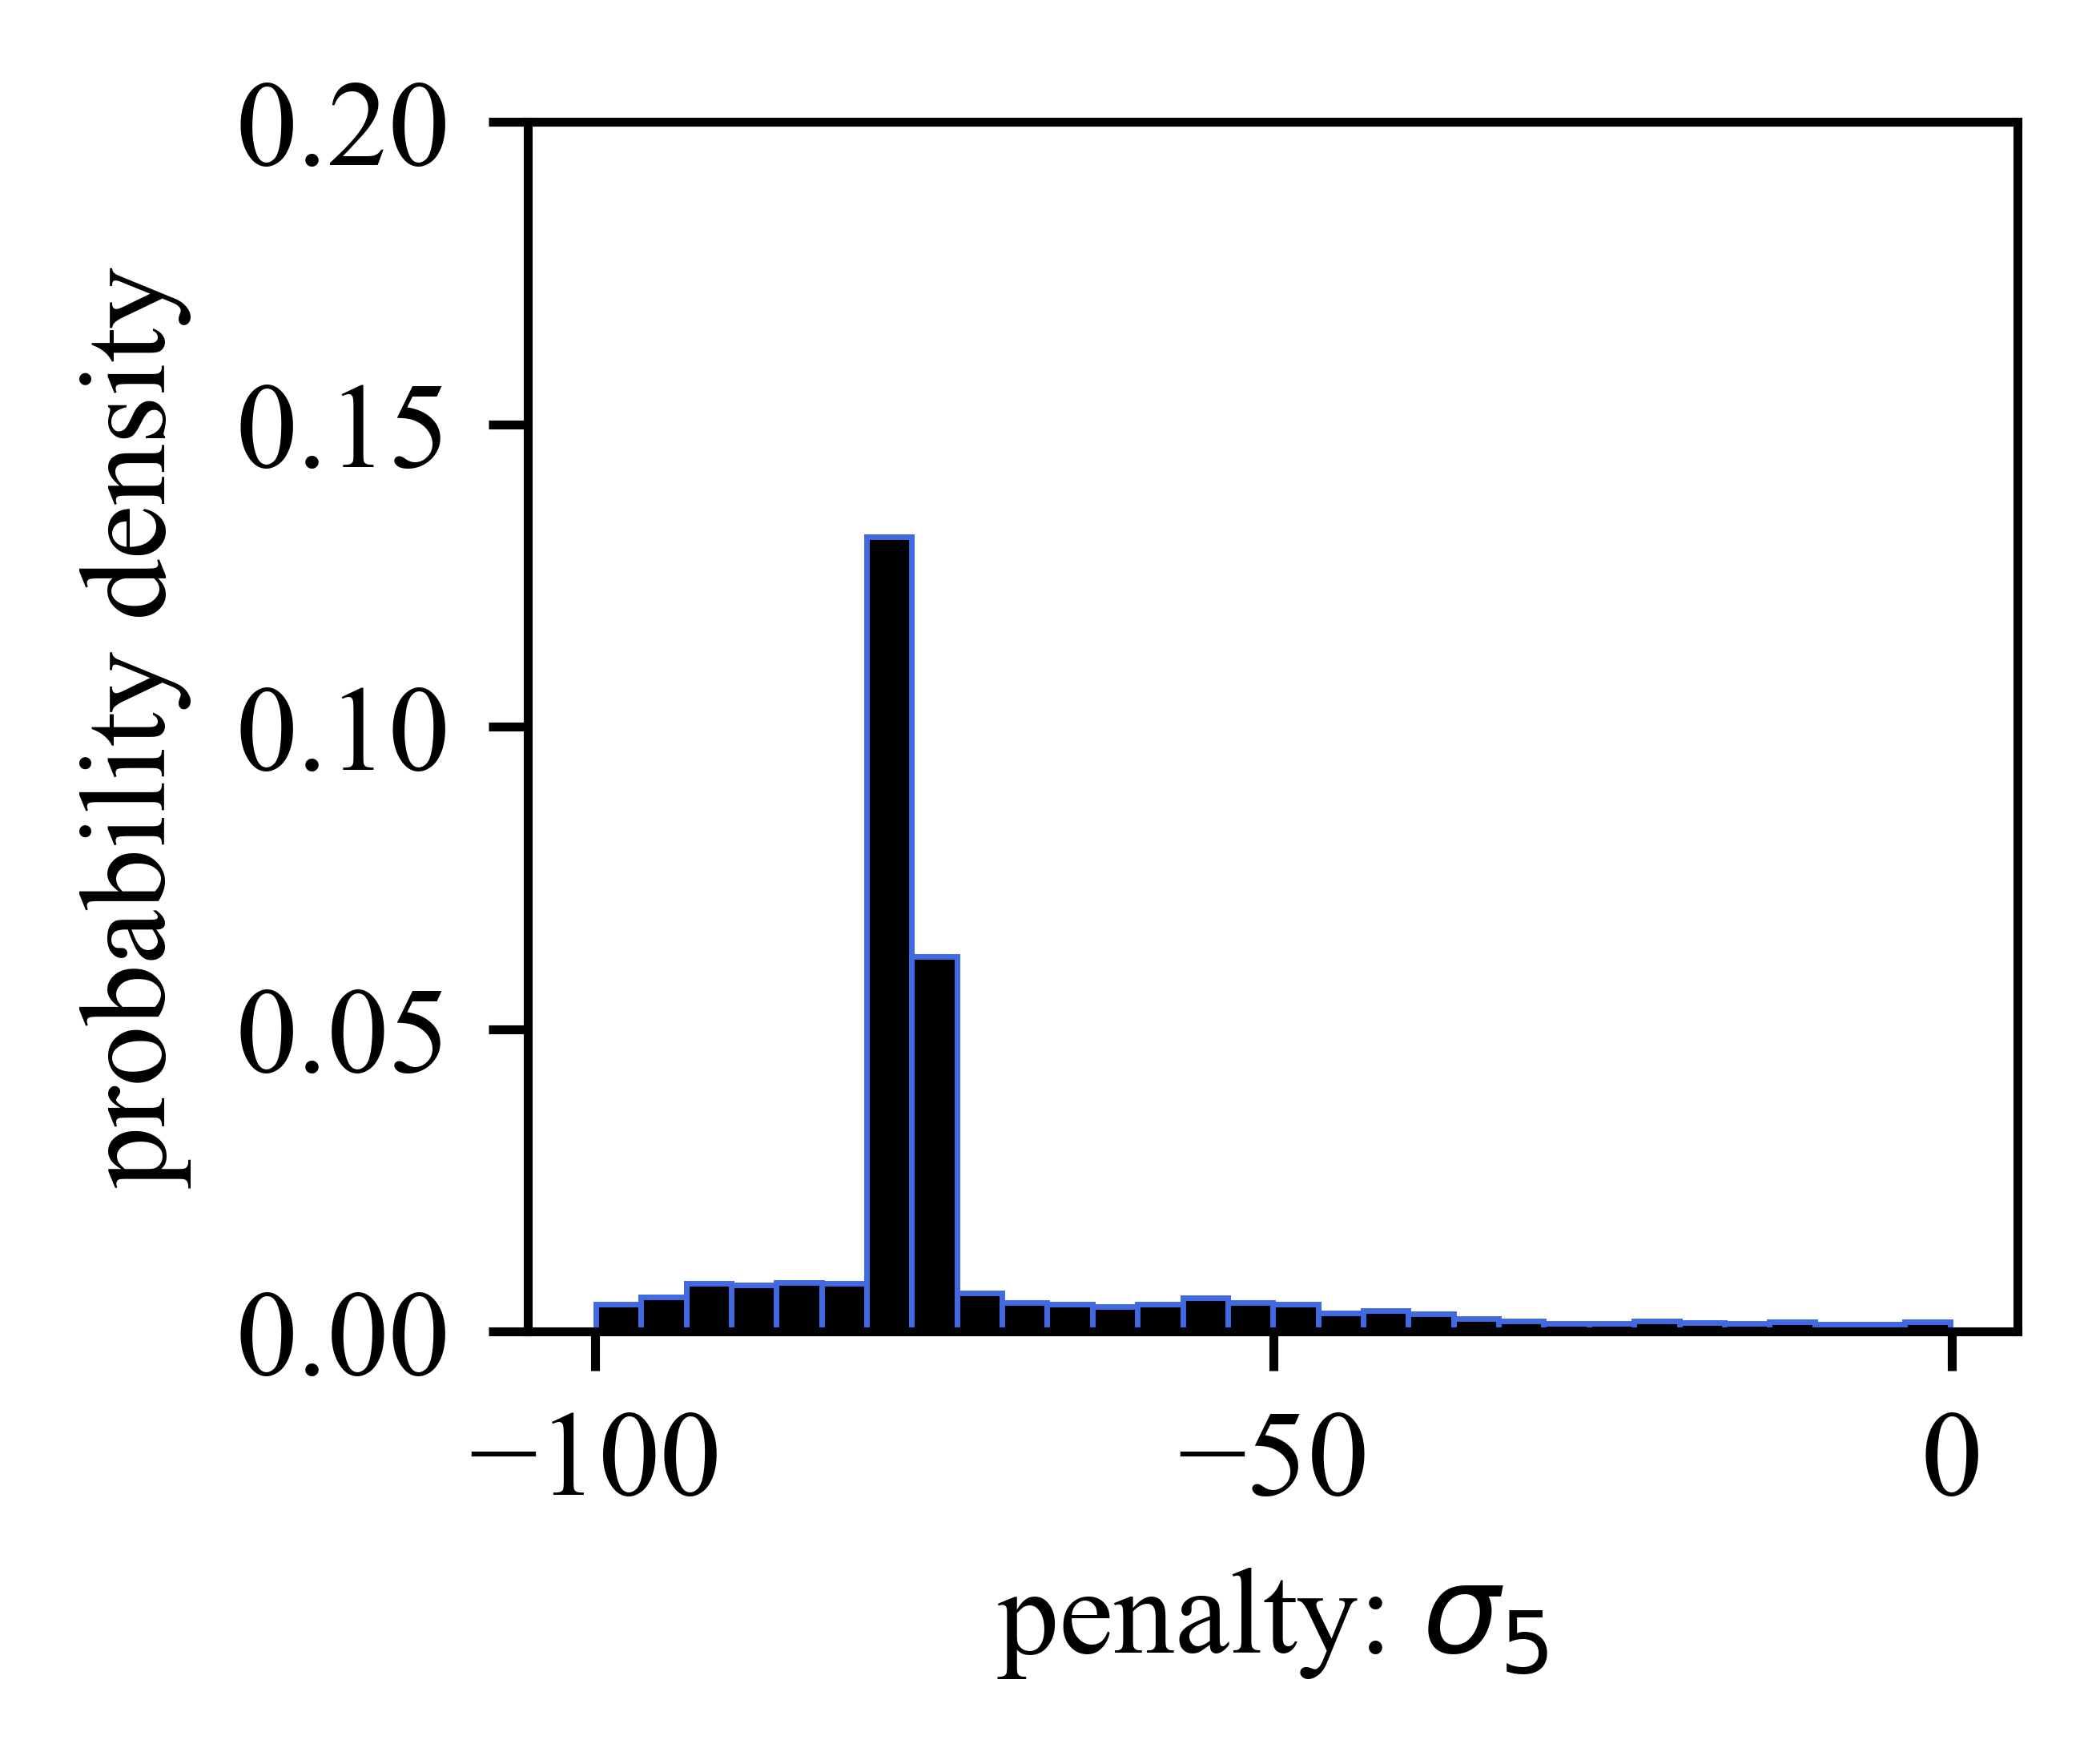

IndexError: list index out of range

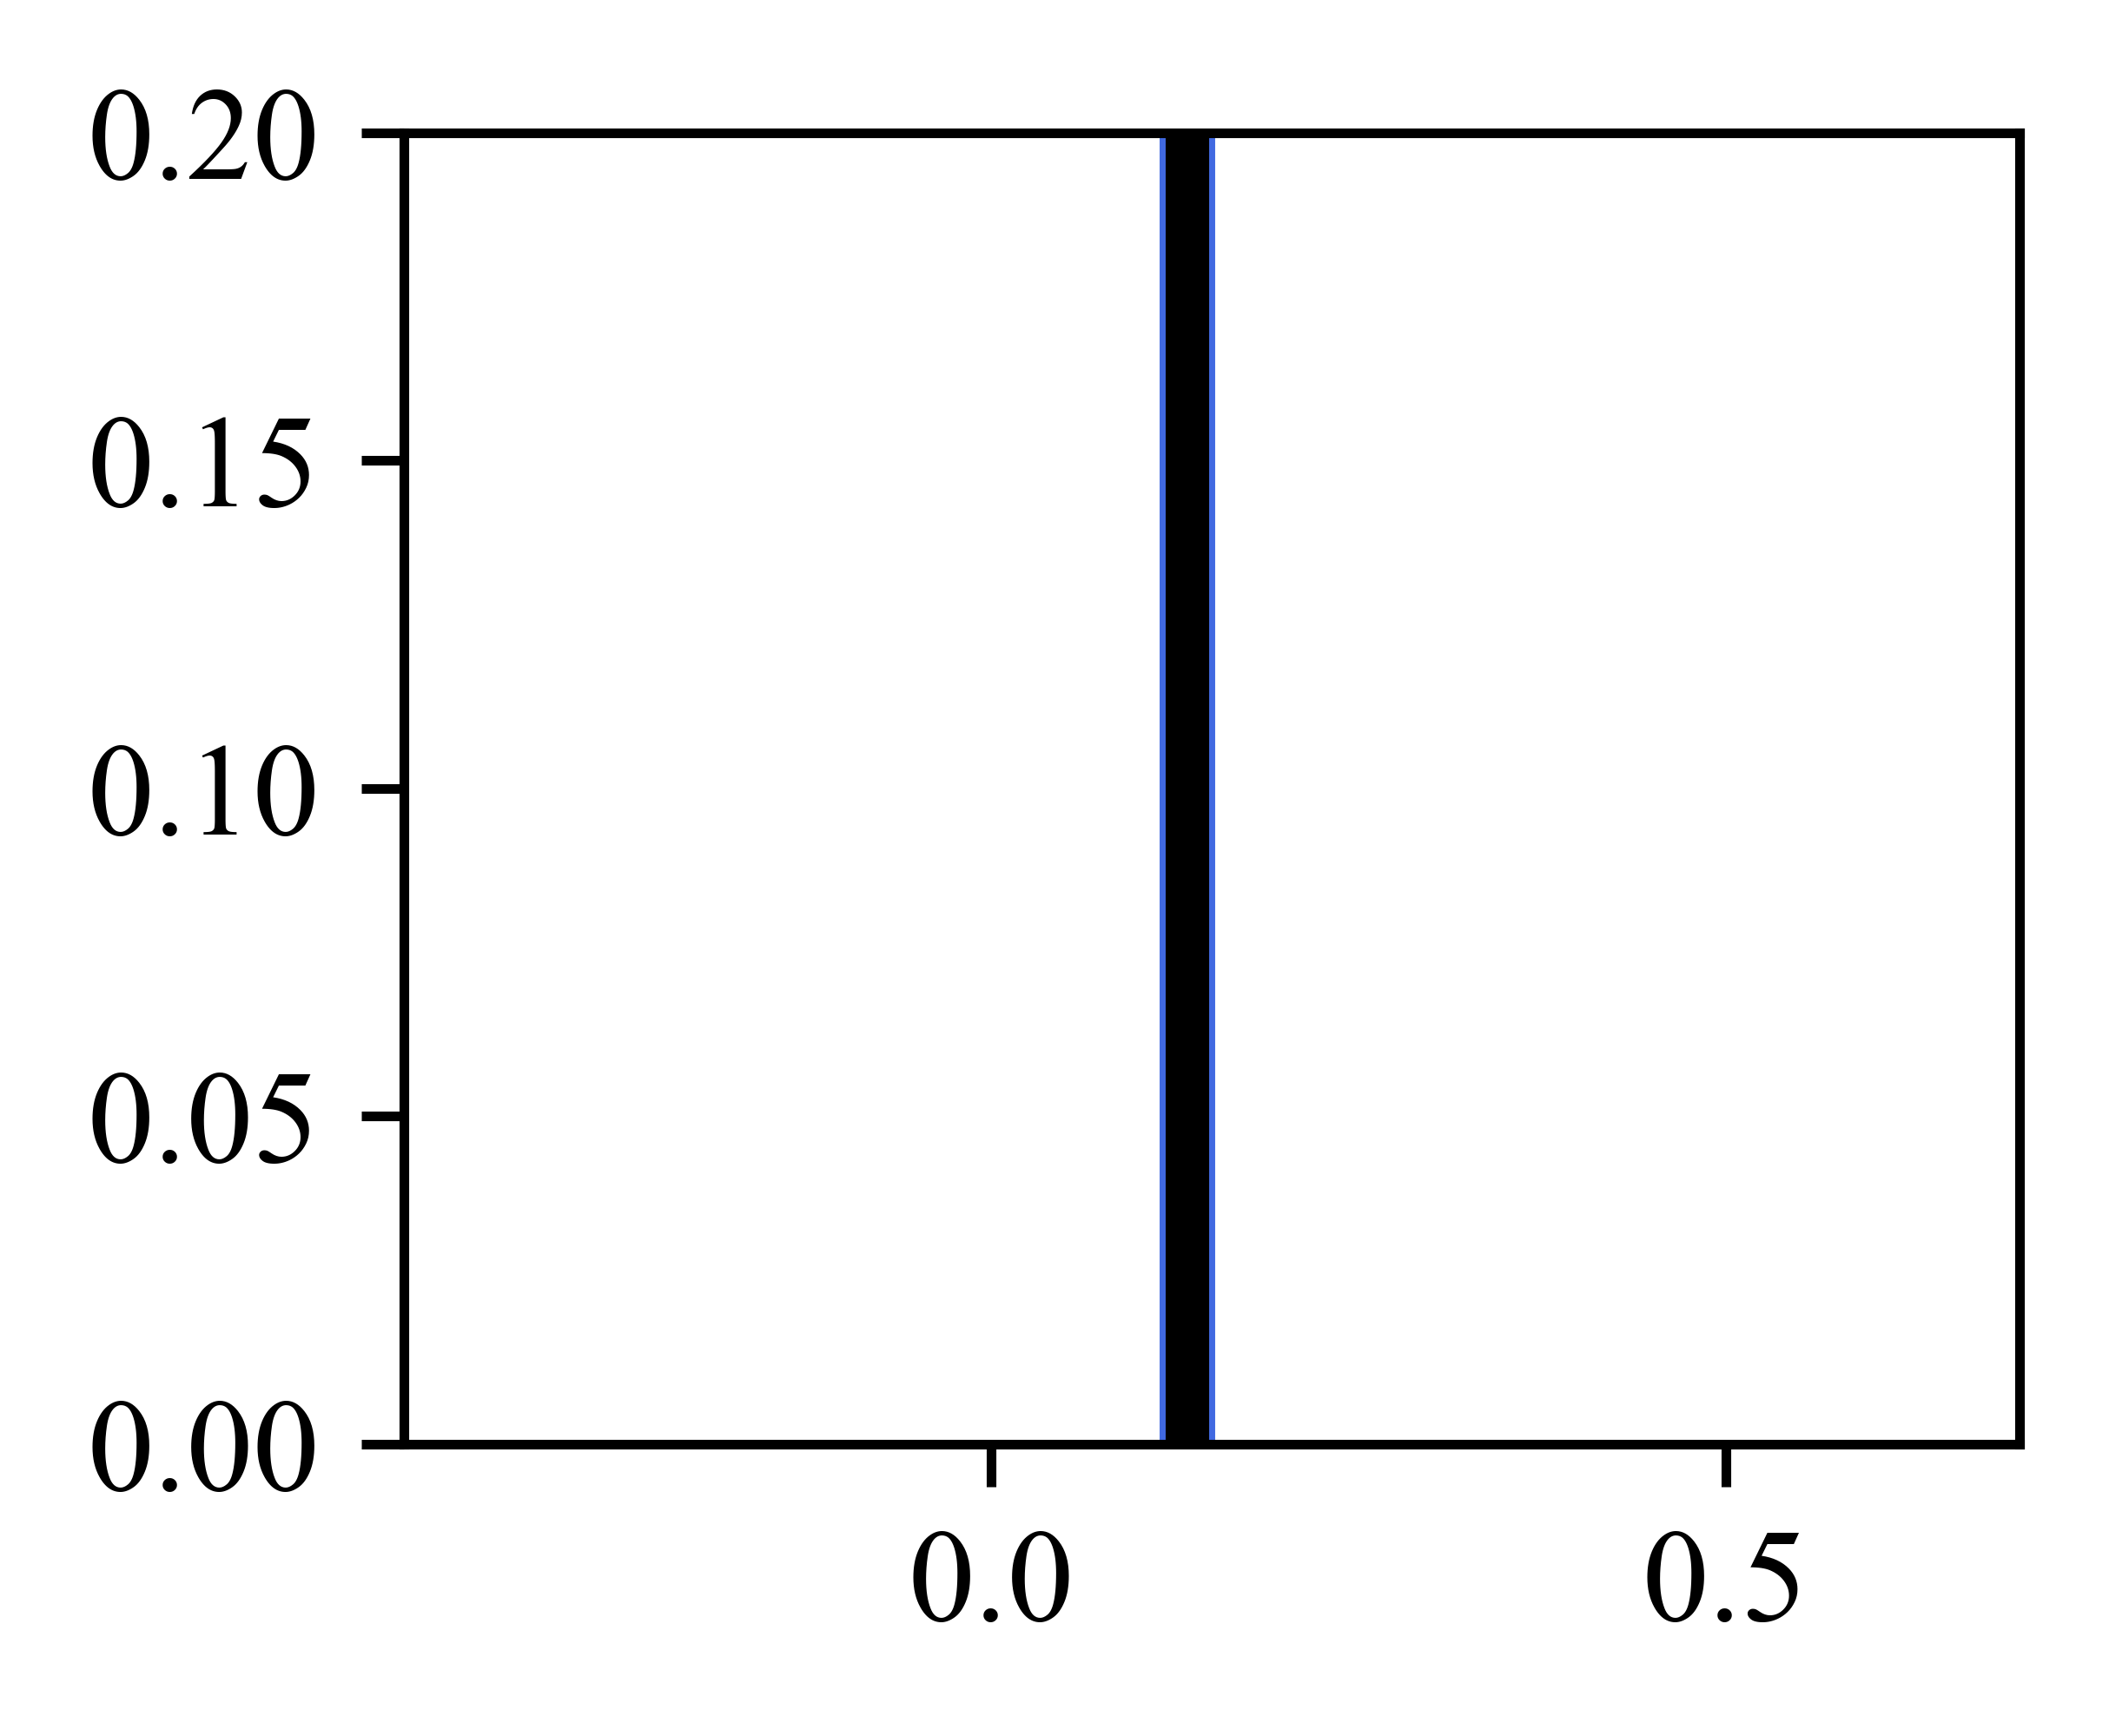

In [19]:
import math
import matplotlib.pyplot as plt 
import importlib
import numpy as np
importlib.reload(plt)
plt.style.use(['grayscale', 'paper_hoch2'])

start = 6000
max_nr = 20000

col_names = ["reward best", "reward imp.", "reward divers", "reward unique", "penalty"]

# perform log transformation
for col in range(len(all_x[0])):
    plt_x = [row[col] for row in all_x[start:max_nr]]
            
    plt.hist(plt_x, bins=30, edgecolor="royalblue", linewidth=0.5, density=True)
    plt.ylim(0, 0.2)
    # plt.plot(reg_x, reg_y, color="royalblue")
    plt.xlabel(f"{col_names[col]}: $\sigma_{col+1}$")
    plt.ylabel(f"probability density")
    # plt.ylabel("mod. z-score")
    plt.show()

# Plot relative values

In [ ]:
import importlib
importlib.reload(plt)
plt.style.use(['grayscale', 'paper_hoch2'])

rel_vals = []
for row in all_x:
    new_row = []
    for i, rew1 in enumerate(row):
        for j, rew2 in enumerate(row[i+1:]):
            new_row.append(rew1/rew2)
            
    rel_vals.append(new_row)
    
# fig, axs = plt.subplots(1, 5, figsize=(50, 10), dpi=200)
titles = [f"$\sigma_{1}$ vs $\sigma_{2}$",
f"$\sigma_{1}$ vs $\sigma_{3}$",
f"$\sigma_{1}$ vs $\sigma_{4}$",
f"$\sigma_{1}$ vs $\sigma_{5}$",
f"$\sigma_{2}$ vs $\sigma_{3}$",
f"$\sigma_{2}$ vs $\sigma_{4}$",
f"$\sigma_{2}$ vs $\sigma_{5}$",
f"$\sigma_{3}$ vs $\sigma_{4}$",
f"$\sigma_{3}$ vs $\sigma_{5}$",
f"$\sigma_{4}$ vs $\sigma_{5}$"]

# perform log transformation
max_nr = 6000
for col in range(len(rel_vals[0][:])):
    plt_x = [math.log(abs(row[col])) for row in rel_vals[:max_nr]]
    plt.scatter(plt_x, all_y[:max_nr], s=0.05)
    plt.xlabel(titles[col])
    plt.ylabel("mod. z-score")
    plt.xlim([-10, 10])
    plt.ylim([-5, 15])
    plt.show()

# Impact of randomness

In [21]:
path = "C:\\Users\\manuf\\OneDrive\\Dokumente\\Universitaet\\Masterthesis\\data\\1_tuning_results\\vrpldtt"
solutions = get_solutions(join(path, "randomness"))

raw_data = [[row["data_id"],
             row["parameter"]["random_noise"],
             row["metrics"]["value"],
             row["metrics"]["iterations"],
             row["metrics"]["solution_time_ms"]]
            for row in solutions]

df = pd.DataFrame(raw_data, columns=[
                  "id", "random_noise", "value", "iterations", "solution_time_ms"])

# modify scores
df["mod_value"] = get_modified_z_scores_ids(df["value"], df["id"])
df["mod_iterations"] = get_modified_z_scores_ids(df["iterations"], df["id"])
df["mod_time"] = get_modified_z_scores_ids(df["solution_time_ms"], df["id"])

# Create plot data
noise_labels = list(set(df["random_noise"]))
noise_data = []

noise_labels.sort()
for temp in noise_labels:
    noise_data.append(df[df["random_noise"] == temp]["mod_value"])

FileNotFoundError: [WinError 3] Das System kann den angegebenen Pfad nicht finden: 'C:\\Users\\manuf\\OneDrive\\Dokumente\\Universitaet\\Masterthesis\\data\\1_tuning_results\\vrpldtt\\high_randomness'

In [ ]:
import importlib
importlib.reload(plt)
plt.style.use(['grayscale', 'paper_hoch'])

f, a0 = plt.subplots()
# f.set_size_inches(18.5, 10.5, forward=True)
# f.set_dpi(200)

a0.set_xlabel(r"random factor: $\rho$", fontdict={"family": "Times New Roman"})
a0.set_ylabel(r"mod. z-score")
_ = a0.boxplot(noise_data, labels=noise_labels)


# Plotting $\rho$ impact

ZeroDivisionError: division by zero

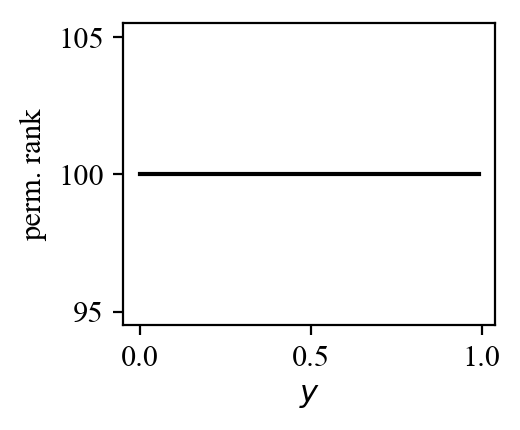

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(style=("paper_hoch2"))

rnd_factor = 0
nr_cust = 100
nr_rem = 10

# 1) Plot rank impact of rnd_factor
x = np.arange(0, 1, 0.01)
y = [v**rnd_factor*nr_cust for v in x]
plt.plot(x, y)
plt.xlabel(r'$y$')
plt.ylabel('perm. rank')

# 2) Plot probability of selection
necessary_rank_factor = nr_rem/nr_cust
p = (nr_rem/nr_cust)**(1/rnd_factor)

# hoirzontal line
plt.plot([0, p], [necessary_rank_factor*nr_cust, necessary_rank_factor*nr_cust], color="royalblue")

# vertical line
plt.plot([p, p], [necessary_rank_factor*nr_cust, 0], color="royalblue")

# 3) Insert annotation!
plt.annotate(f'$\leq y$ = {round(p,2)}',
             xy=(p/2, necessary_rank_factor*nr_cust+(nr_cust/10)),
             xytext=(p/2, necessary_rank_factor*nr_cust+(nr_cust/5)), 
             fontsize=12, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle=f'-[, widthB={(p/2)*10}, lengthB=0.5'))

plt.show()

# Plotting $\omega$ impact

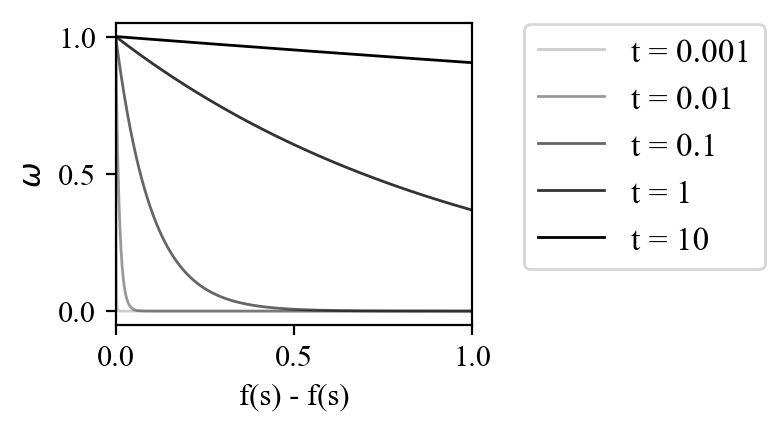

In [104]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(style=("grayscale", "paper_hoch2"))

max_diff = 1
ts = [10, 1, 0.1, 0.01, 0.001]
ts.sort()

# 1) Plot rank impact of rnd_factor
q_diff = np.arange(0.0001, max_diff, (max_diff-0.0001)/1000)

ys = []
for t in ts:
    y = [np.exp(-(v/t)) if np.exp(-(v/t)) < 1 else 1 for v in q_diff]
    ys.append(y)

for i, y in enumerate(ys):
    plt.plot(q_diff, y, color="black", alpha=(i+1)*(1/len(ts)), linewidth=1)
    
plt.xlabel(r'f(s) - f(s)')
plt.xlim(0,max_diff)
plt.ylabel(f'$\omega$')

plt.legend([f"t = {t}" for t in ts], bbox_to_anchor=(1.1, 1.05), prop={'size': 12})

# hoirzontal line
plt.show()

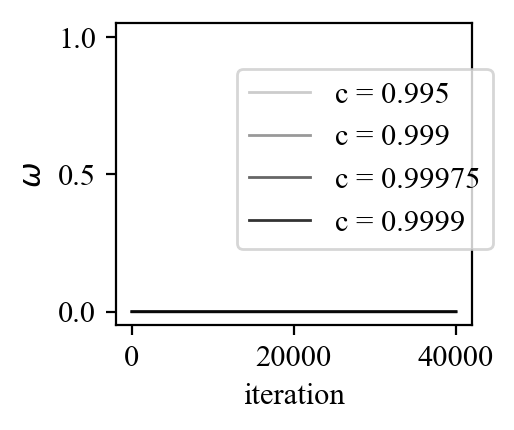

In [3]:
y = []


    
    
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(style=("grayscale", "paper_hoch2"))

ts = [10, 1, 0.1, 0.01, 0.001]
ts.sort()

# 1) Plot rank impact of rnd_factor
diff = 100
T = 10
cs = [0.995, 0.999, 0.99975, 0.9999]
it = 40000
ys = []
for c in cs:
    y = []
    t = T
    for x in range(it):
        t *= c
        if np.exp(-(diff/t)) < 1:
            prob = np.exp(-(diff/t))
        else:
            prob = 1
        y.append(prob)
    ys.append(y)

for i, y in enumerate(ys):
    plt.plot(range(it), y, color="black", alpha=(i+1)*(1/len(ts)), linewidth=1)
    
plt.ylim(-0.05, 1.05)
plt.xlabel(r'iteration')
plt.ylabel(f'$\omega$')

plt.legend([f"c = {c}" for c in cs], bbox_to_anchor=(1.1, 0.9), prop={'size': 11})

# hoirzontal line
plt.show()

# Memory length

In [5]:
# 1) Import data
path = "C:\\Users\\manuf\\OneDrive\\Dokumente\\Universitaet\\Masterthesis\\data\\1_tuning_results\\vrpldtt"
solutions = get_solutions(join(path, "5_memory_length"))

raw_data = [[sol["data_id"],
             sol["parameter"]["wheel_parameter"],
             sol["parameter"]["wheel_memory_length"],
             sol["metrics"]["value"],
             sol["metrics"]["iterations"],
             sol["metrics"]["solution_time_ms"]]
            for sol in solutions]

# 2) Transform data
df = pd.DataFrame(raw_data, columns=[
                  "id", "wheel_parameter", "wheel_memory_length", "value", "iterations", "solution_time_ms"])

df["mod_value"] = get_modified_z_scores_ids(df["value"], df["id"])
df["mod_iterations"] = get_modified_z_scores_ids(df["iterations"], df["id"])
df["mod_time"] = get_modified_z_scores_ids(df["solution_time_ms"], df["id"])


memory_labels = list(set(df["wheel_memory_length"]))
memory_labels.sort()
memory_data = []
for temp in memory_labels:
    memory_data.append(df[df["wheel_memory_length"] == temp].loc[:3000,"mod_value"])

Text(0,0.5,'mod. z-score')

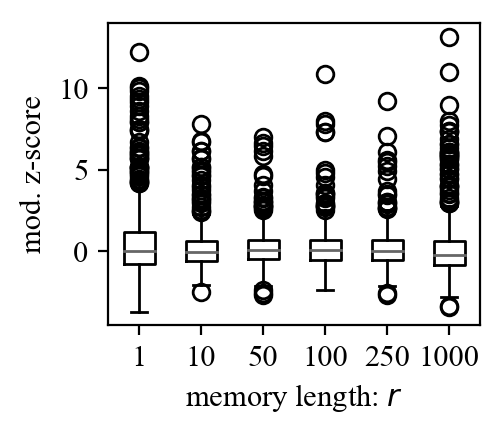

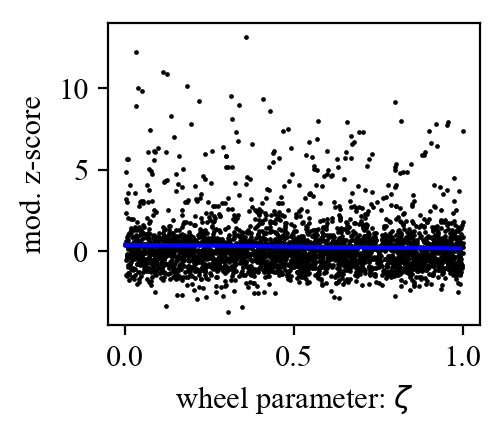

In [8]:
#4) Plotting
plt.style.use(['grayscale', 'paper_hoch2'])
f, ax = plt.subplots()
_ = ax.boxplot(memory_data, labels=memory_labels)
ax.set_xlabel(r"memory length: $r$")
ax.set_ylabel("mod. z-score")


# Plot wheel parameter
# train regression line on it!
f, ax = plt.subplots()
m,b = np.polyfit(df.loc[:3000,"wheel_parameter"], df.loc[0:3000, "mod_value"], 1)
reg_x = list(np.arange(0, 1, 0.01))
reg_y = [m*x + b for x in reg_x]
_ = ax.scatter(df.loc[0:3000,"wheel_parameter"], df.loc[0:3000, "mod_value"], s=0.5)
_ = ax.plot(reg_x, reg_y, color="blue")
ax.set_xlabel(r"wheel parameter: $\zeta$")
ax.set_ylabel("mod. z-score")

## Appendix: All parameter combinations

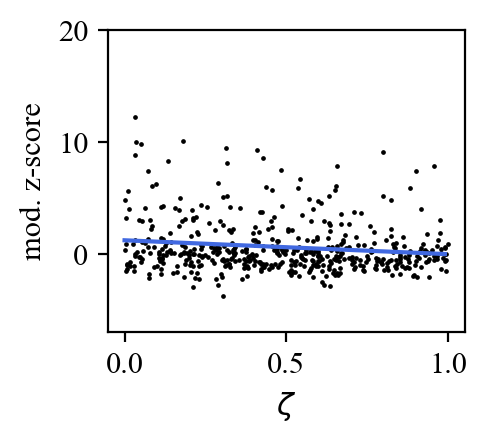

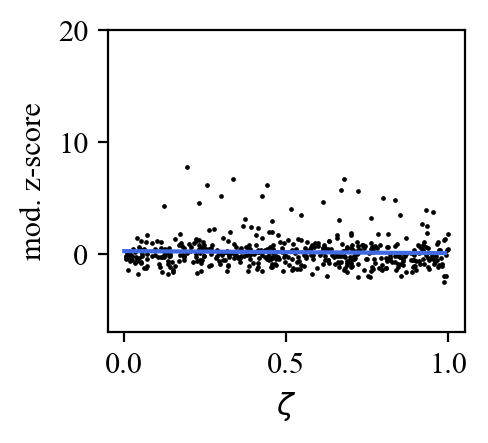

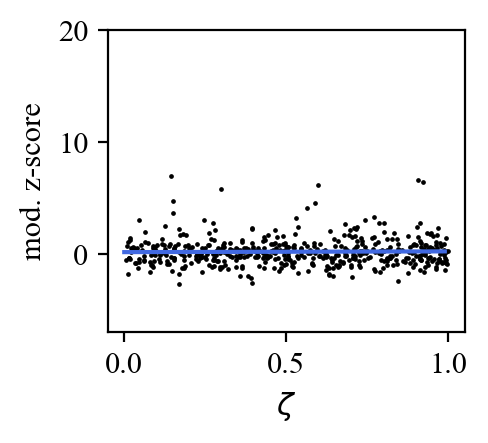

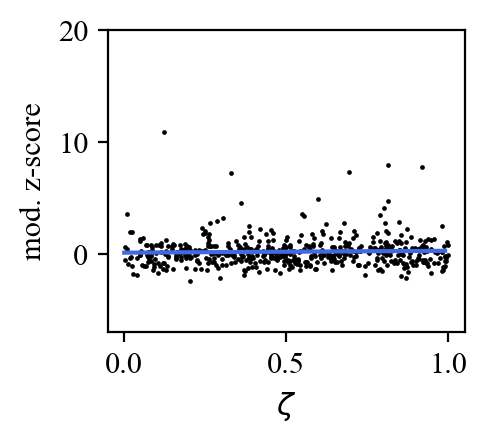

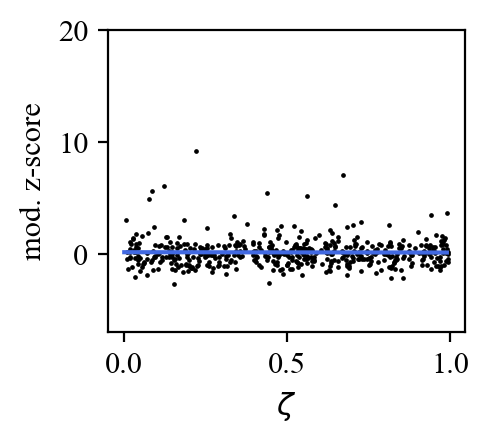

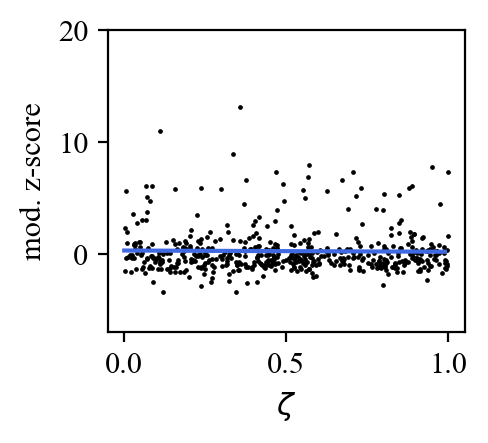

In [14]:
#1) Sort values
df2 = df["wheel_memory_length"]

memory_labels = list(set(df["wheel_memory_length"]))
memory_labels.sort()

parameter_vals = []
parameter_zscores = []
for temp in memory_labels:
    parameter_vals.append(df[df["wheel_memory_length"] == temp].loc[:3000, "wheel_parameter"])
    parameter_zscores.append(df[df["wheel_memory_length"] == temp].loc[:3000, "mod_value"])

# 2) Plot
plt.style.use(['grayscale', 'paper_hoch2'])
for memlen_id in range(len(parameter_vals)):
    x = parameter_vals[memlen_id]
    y = parameter_zscores[memlen_id]
        
    f, ax = plt.subplots()
    m,b = np.polyfit(x, y, 1)
    reg_x = list(np.arange(0, 1, 0.01))
    reg_y = [m*x + b for x in reg_x]
    _ = ax.scatter(x, y, s=0.5, color="k")
    _ = ax.plot(reg_x, reg_y, color="royalblue")
    ax.set_ylim((-7, 20))
    ax.set_xlabel(f"$\zeta$")
    ax.set_ylabel("mod. z-score")

## Target infeasibility

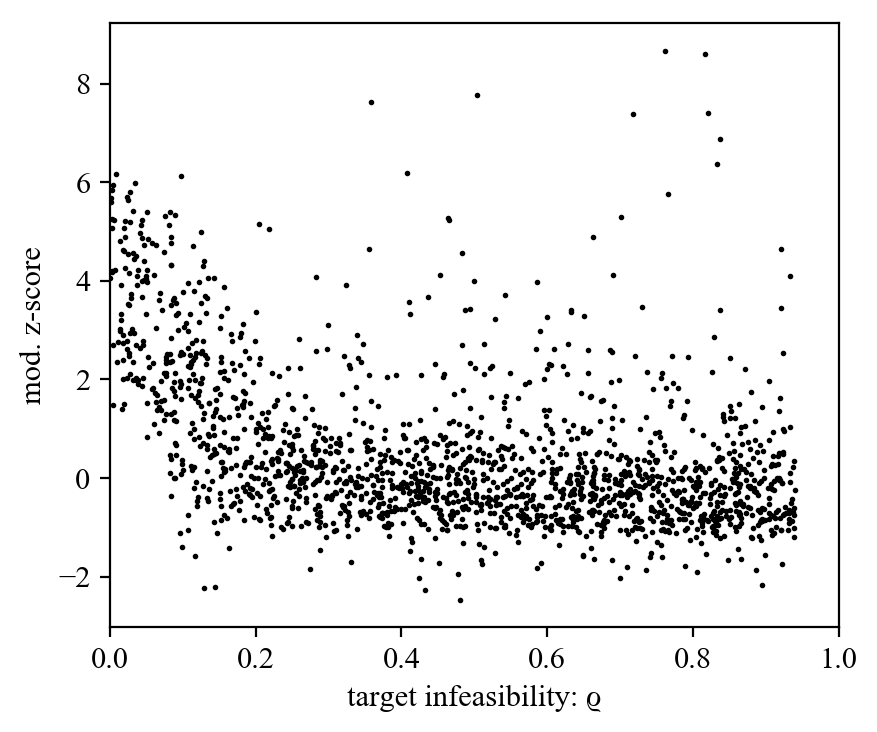

In [15]:
# 1) Import data
plt.style.use(['grayscale', 'paper_hoch'])
path = "C:\\Users\\manuf\\OneDrive\\Dokumente\\Universitaet\\Masterthesis\\data\\1_tuning_results\\vrpldtt"
solutions = get_solutions(join(path, "6_target_inf"))

raw_data = [[sol["data_id"],
             sol["parameter"]["target_inf"],
             sol["metrics"]["value"]]
            for sol in solutions]

# 2) Transform data
df = pd.DataFrame(raw_data, columns=["id", "target_inf", "value"])
df["mod_value"] = get_modified_z_scores_ids(df["value"], df["id"])

# 3) Plot
len_init = 1800


scatter_reg_plot(x=df.loc[:len_init, "target_inf"],
                 y=df.loc[:len_init, "mod_value"],
                 xlabel=f"target infeasibility: ϱ",
                 ylabel="mod. z-score",
                xlim=[0,1])

# Do operator performance

In [5]:
# 1) Import data
dat_path = "C:\\Users\\manuf\\OneDrive\\Dokumente\\Universitaet\\Masterthesis\\data\\1_tuning_results\\vrpldtt"

solutions = get_solutions(join(dat_path, "7_operators"))

raw_data = [[row["data_id"],
             row["parameter"]["destroy_operators"],
             row["parameter"]["repair_operators"],
             row["metrics"]["value"],
             row["metrics"]["iterations"],
             row["metrics"]["solution_time_ms"]]
            for row in solutions]

df = pd.DataFrame(raw_data, columns=[
                  "id", "destroy_operators", "repair_operators", "value", "iterations", "solution_time_ms"])

# 2) Remove outliers
df = df[df["value"] < 20000]

# 3) Transform data
df["mod_value"] = get_modified_z_scores_ids(df["value"], df["id"])
df["mod_iterations"] = get_modified_z_scores_ids(df["iterations"], df["id"])
df["mod_time"] = get_modified_z_scores_ids(df["solution_time_ms"], df["id"])

# 4) Transform data into plottable format
label_dest = ["random_destroy", "route_destroy", "demand_destroy", "time_destroy",
              "node_pair_destroy",
              "shaw_destroy", "worst_destroy", "distance_similarity",
              "window_similarity",
              "demand_similarity"]
data_dest = []
for i, x in enumerate(label_dest):
    tmp_df = df[df["destroy_operators"].apply(lambda row: x in row)]
    data_dest.append(tmp_df[tmp_df["mod_value"] < 3.5]["mod_value"])

    
label_rep = ["2_regret", "3_regret", "5_regret", "basic_greedy", "random_greedy",
                                                 "deep_greedy", "beta_hybrid"]
data_rep = []
for i, x in enumerate(label_rep):
    tmp_df = df[df["repair_operators"].apply(lambda row: x in row)]
    data_rep.append(tmp_df[tmp_df["mod_value"] < 3.5]["mod_value"])
    

Text(0,0.5,'mod. z-scores')

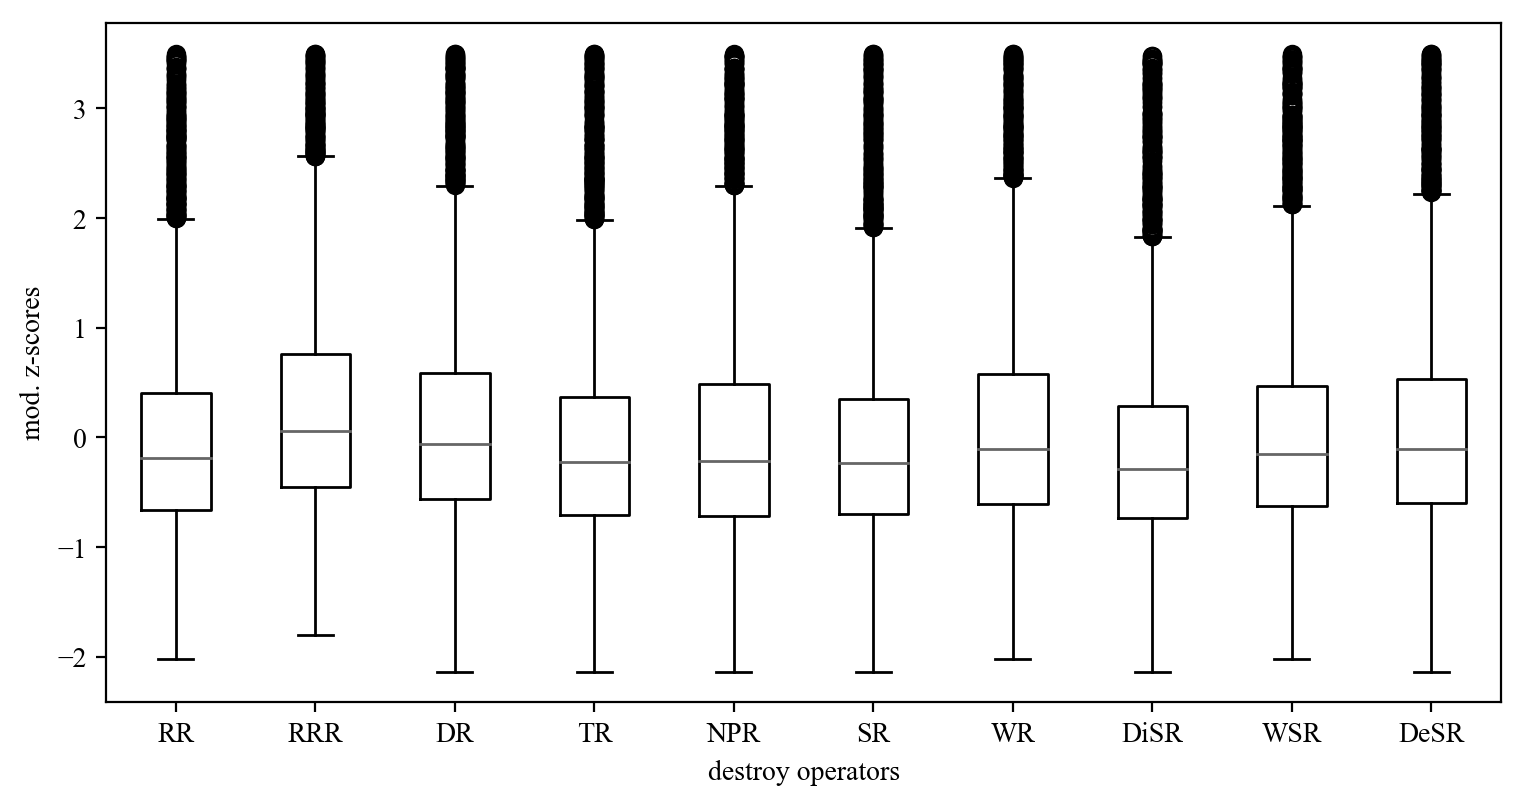

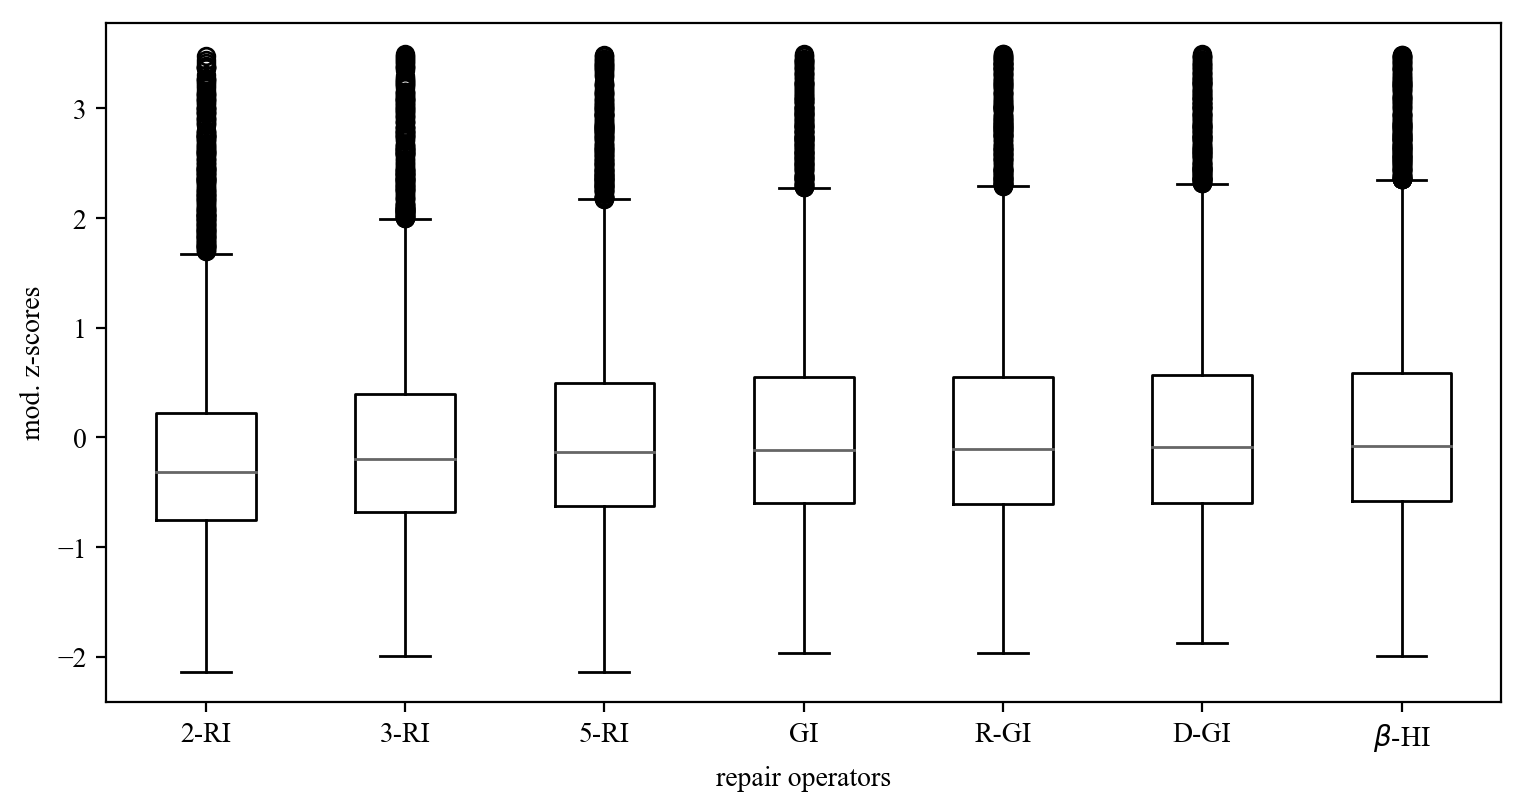

In [23]:
import matplotlib.pyplot as plt
import importlib
%matplotlib inline

importlib.reload(plt)
plt.style.use(['grayscale', 'paper_quer'])

fig, ax = plt.subplots()
fig.set_size_inches(9, 4.5, forward=True) #adjust size to fit double lined caption
_ = ax.boxplot(data_dest, labels=["RR", "RRR", "DR", "TR", "NPR", "SR", "WR", "DiSR", "WSR", "DeSR"])
ax.set_xlabel("destroy operators")
ax.set_ylabel("mod. z-scores")
plt.show

fig, ax = plt.subplots()
fig.set_size_inches(9, 4.5, forward=True) #adjust size to fit double lined caption
_ = ax.boxplot(data_rep, labels=["2-RI", "3-RI", "5-RI", "GI", "R-GI", "D-GI", r"$ \beta $-HI"])
ax.set_xlabel("repair operators")
ax.set_ylabel("mod. z-scores")

# Compare performance after each tuning step

This is done by using the last 180 iterations of all tuning steps!

In [7]:
# PROBLEM: First two researches have been performed with different data -> Must be recomputed
tuning_results = [f"b{i}" for i in range(1,6)]

data = []
for folder in tuning_results:
    path = "C:\\Users\\manuf\\OneDrive\\Dokumente\\Universitaet\\Masterthesis\\data\\1_tuning_results\\vrpldtt\\99_tuning_benefit"
    solutions = get_solutions(join(path, folder))
    
    bucket_data = []
    # Get the last 180 solutions -> best tuning results!
    for sol in solutions:
        bucket_data.append((folder,
                            sol["data_id"], 
                            sol["metrics"]["value"],
                            sol["metrics"]["iterations"], 
                            sol["metrics"]["solution_time_ms"]))
    
    data.extend(bucket_data)
    
df = pd.DataFrame(data, columns=["bucket", "id", "value", "iterations", "solution_time_ms"])

df["mod_value"] = get_modified_z_scores_ids(df["value"], df["id"])
df["mod_iterations"] = get_modified_z_scores_ids(df["iterations"], df["id"])
df["mod_time"] = get_modified_z_scores_ids(df["solution_time_ms"], df["id"])

Text(0,0.5,'mod. iterations')

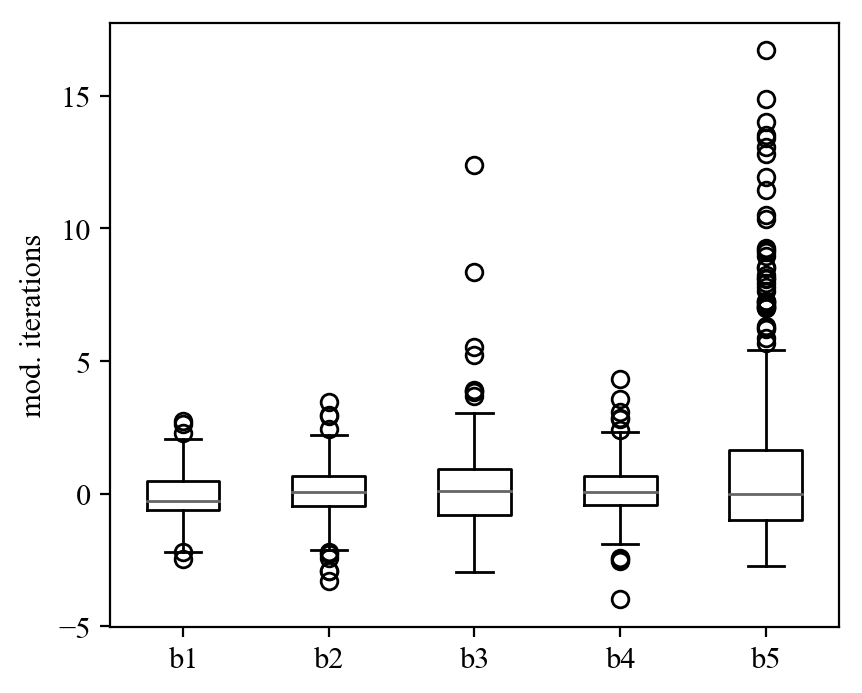

In [18]:
plt.style.use(['grayscale', 'paper_hoch'])

plt_dat = []
for tune_name in tuning_results:
    plt_dat.append(df[df["bucket"] == tune_name]["mod_iterations"])
    
f, ax = plt.subplots()
_ = ax.boxplot(plt_dat, labels=tuning_results)
# ax.set_xlabel("")
ax.set_ylabel("mod. iterations")

Text(0,0.5,'mod. z-score')

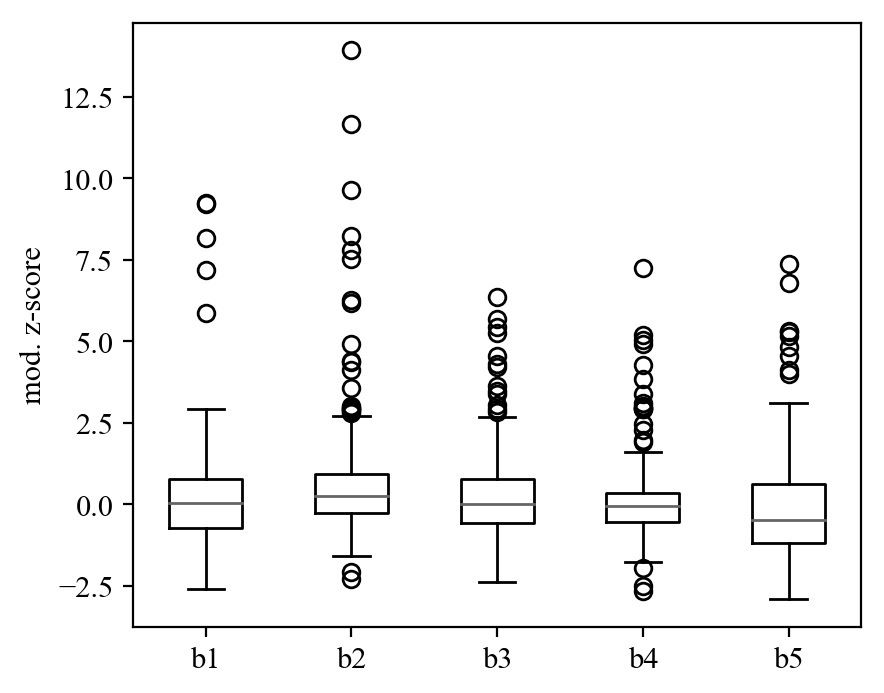

In [19]:
plt.style.use(['grayscale', 'paper_hoch'])

plt_dat = []
for tune_name in tuning_results:
    plt_dat.append(df[df["bucket"] == tune_name]["mod_value"])
    
f, ax = plt.subplots()
_ = ax.boxplot(plt_dat, labels=tuning_results)
# ax.set_xlabel("")
ax.set_ylabel("mod. z-score")

# Get BKS

In [82]:
# get best solution of all iterations!
tuning_results = ["4_operator_weights", "5_memory_length", "6_target_inf", "7_operators"]

data = []
for folder in tuning_results:
    path = "C:\\Users\\manuf\\OneDrive\\Dokumente\\Universitaet\\Masterthesis\\data\\1_tuning_results\\vrpldtt"
    solutions = get_solutions(join(path, folder))
    
    bucket_data = []
    # Get the last 180 solutions -> best tuning results!
    for sol in solutions:
        bucket_data.append((folder,
                            sol["data_id"], 
                            sol["metrics"]["value"]))
    
    data.extend(bucket_data)
    
all_df = pd.DataFrame(data, columns=["bucket", "id", "value"])

for id in range(0, 6):
    df_spec = all_df[(all_df["id"] == id)]
    print(df_spec[df_spec["value"] == df_spec["value"].min()])

            bucket  id        value
35453  7_operators   0  1029.683748
                bucket  id        value
21395  5_memory_length   1  1013.363959
            bucket  id       value
36078  7_operators   2  145.886127
            bucket  id       value
27187  7_operators   3  145.256355
                bucket  id       value
23406  5_memory_length   4  384.953218
                  bucket  id       value
1767  4_operator_weights   5  365.424012


In [ ]:
plt.style.use(['grayscale', 'paper_hoch'])

plt_dat = []
for tune_name in tuning_results:
    plt_dat.append(df[df["bucket"] == tune_name]["mod_iterations"])
    
f, ax = plt.subplots()
_ = ax.boxplot(plt_dat, labels=tuning_results)
# ax.set_xlabel("")
# ax.set_ylabel("mod. z-score")

Standard deviation of results and min is {16/1030}